# Librerias

In [1]:
#Se importan las librerías necesarias para el problema
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
import copy
from pycaret.classification import *
from sklearn.utils import shuffle

import warnings

warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (15, 10)

In [182]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import lightgbm as ltb
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV

## Problema

El problema consiste en predecir la probabilidad de atraso de los vuelos que aterrizan o despegan del aeropuerto de Santiago
de Chile (SCL). Para eso les entregamos un dataset usando datos públicos y reales donde cada fila corresponde a un vuelo
que aterrizó o despegó de SCL. Para cada vuelo se cuenta con la siguiente información:

* **Fecha-I** : Fecha y hora programada del vuelo.
* **Vlo-I** : Número de vuelo programado.
* **Ori-I** : Código de ciudad de origen programado.
* **Des-I** : Código de ciudad de destino programado.
* **Emp-I** : Código aerolínea de vuelo programado.
* **Fecha-O** : Fecha y hora de operación del vuelo.
* **Vlo-O** : Número de vuelo de operación del vuelo.
* **Ori-O** : Código de ciudad de origen de operación
* **Des-O** : Código de ciudad de destino de operación.
* **Emp-O** : Código aerolínea de vuelo operado.
* **DIA** : Día del mes de operación del vuelo.
* **MES** : Número de mes de operación del vuelo.
* **AÑO** : Año de operación del vuelo.
* **DIANOM** : Día de la semana de operación del vuelo.
* **TIPOVUELO** : Tipo de vuelo, I =Internacional, N =Nacional.
* **OPERA** : Nombre de aerolínea que opera.
* **SIGLAORI** : Nombre ciudad origen.
* **SIGLADES** : Nombre ciudad destino.

### 0. Obtención de datos

In [3]:
df = pd.read_csv('dataset_SCL.csv')

- Se da formato *datetime64* a campos Fecha-I y Fecha-O

In [4]:
df['Fecha-I'] = df['Fecha-I'].astype('datetime64[ns]')
df['Fecha-O'] = df['Fecha-O'].astype('datetime64[ns]')

- Se extrae información de las distancias en millas de los vuelos programados (Fuente de información: http://www.gcmap.com/)

In [5]:
r = requests.get( 
    'http://www.gcmap.com/dist?P=' +
    ','.join( (df['Ori-I'] +'-'+ df['Des-I']).drop_duplicates().values ) +
    ',&MS=bm&MP=rect&PC=#ffff00'
)
df_dist = pd.read_html( r.content )[1].iloc[:-3]

Se extrae información de API de *Atlas de Riesgos Climáticos para Chile* : 
- daily_temperature_range:
- number_of_heavy_precipitation_days:
- number_of_very_heavy_precipitation_days:
- vel_max:

In [6]:
l_month = {'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,'jul':7,'ago':8,'sep':9,'oct':10,'nov':11,'dec':12}

In [7]:
r = requests.get( 'https://arclim.mma.gob.cl/api/datos/regiones/json/?attributes=NOM_REGION,$CLIMAS$daily_temperature_range$annual$present', verify = requests.certs.where() )
df_dtr = pd.DataFrame( json.loads(r.text)['data']['values'], columns=['Region','daily_temperature_range_annual'] )


for i in l_month:
    url = 'https://arclim.mma.gob.cl/api/datos/regiones/json/?attributes=NOM_REGION,$CLIMAS$daily_temperature_range$'+i+'$present'
    r = requests.get( url, verify = requests.certs.where() )
    s = l_month[i]
    df_piv = pd.DataFrame( json.loads(r.text)['data']['values'], columns=['Region',s] )

    l_col = df_dtr.columns.values.tolist()
    l_col.append(s)

    df_dtr =  pd.merge(
        df_dtr,
        df_piv,
        right_on = 'Region',
        left_on = 'Region',
        suffixes = ['','_2']
    )[l_col]

df_dtr.loc[ df_dtr['Region'] == 'REGIÓN METROPOLITANA DE SANTIAGO', 'CODIGO' ] = 'SCEL'

In [8]:
r = requests.get( 'https://arclim.mma.gob.cl/api/datos/regiones/json/?attributes=NOM_REGION,$CLIMAS$number_of_heavy_precipitation_days$annual$present', verify = requests.certs.where() )
df_nhpd = pd.DataFrame( json.loads(r.text)['data']['values'], columns=['Region','number_of_heavy_precipitation_days'] )


for i in l_month:
    url = 'https://arclim.mma.gob.cl/api/datos/regiones/json/?attributes=NOM_REGION,$CLIMAS$number_of_heavy_precipitation_days$'+i+'$present'
    r = requests.get( url, verify = requests.certs.where() )
    s = l_month[i]
    df_piv = pd.DataFrame( json.loads(r.text)['data']['values'], columns=['Region',s] )

    l_col = df_nhpd.columns.values.tolist()
    l_col.append(s)

    df_nhpd =  pd.merge(
        df_nhpd,
        df_piv,
        right_on = 'Region',
        left_on = 'Region',
        suffixes = ['','_2']
    )[l_col]

df_nhpd.loc[ df_nhpd['Region'] == 'REGIÓN METROPOLITANA DE SANTIAGO', 'CODIGO' ] = 'SCEL'

In [9]:
r = requests.get( 'https://arclim.mma.gob.cl/api/datos/regiones/json/?attributes=NOM_REGION,$CLIMAS$number_of_very_heavy_precipitation_days$annual$present', verify = requests.certs.where() )
df_nvhpd = pd.DataFrame( json.loads(r.text)['data']['values'], columns=['Region','number_of_very_heavy_precipitation_days'] )


for i in l_month:
    url = 'https://arclim.mma.gob.cl/api/datos/regiones/json/?attributes=NOM_REGION,$CLIMAS$number_of_very_heavy_precipitation_days$'+i+'$present'
    r = requests.get( url, verify = requests.certs.where() )
    s = l_month[i]
    df_piv = pd.DataFrame( json.loads(r.text)['data']['values'], columns=['Region',s] )

    l_col = df_nvhpd.columns.values.tolist()
    l_col.append(s)

    df_nvhpd =  pd.merge(
        df_nvhpd,
        df_piv,
        right_on = 'Region',
        left_on = 'Region',
        suffixes = ['','_2']
    )[l_col]

df_nvhpd.loc[ df_nvhpd['Region'] == 'REGIÓN METROPOLITANA DE SANTIAGO', 'CODIGO' ] = 'SCEL'

In [10]:
r = requests.get( 'https://arclim.mma.gob.cl/api/datos/regiones/json/?attributes=NOM_REGION,$CLIMAS$vel_max$annual$present', verify = requests.certs.where() )
df_vel_max = pd.DataFrame( json.loads(r.text)['data']['values'], columns=['Region','vel_max'] )


for i in l_month:
    url = 'https://arclim.mma.gob.cl/api/datos/regiones/json/?attributes=NOM_REGION,$CLIMAS$vel_max$'+i+'$present'
    r = requests.get( url, verify = requests.certs.where() )
    s = l_month[i]
    df_piv = pd.DataFrame( json.loads(r.text)['data']['values'], columns=['Region',s] )

    l_col = df_vel_max.columns.values.tolist()
    l_col.append(s)

    df_vel_max =  pd.merge(
        df_vel_max,
        df_piv,
        right_on = 'Region',
        left_on = 'Region',
        suffixes = ['','_2']
    )[l_col]

df_vel_max.loc[ df_vel_max['Region'] == 'REGIÓN METROPOLITANA DE SANTIAGO', 'CODIGO' ] = 'SCEL'

- Se renombran columnas de DataFrame df_dist

In [11]:
df_dist = df_dist.rename(columns={
    'From': 'Origen',
    'To' : 'Destino',
    'Initial Heading' : 'Inicio_Coordenada',
    'Initial Heading.1' : 'Inicio_Sentido',
    'Magnetic Heading' : 'Destino_Coordenada',
    'Magnetic Heading.1' : 'Destino_Sentido',
    'Distance' : 'Distancia_millas'
})

In [12]:
df_dist[[
    'latitud_grados',
    'latitud_minutos',
    'latitud_segundos',
    'latitud',
    'longitud_grados',
    'longitud_minutos',
    'longitud_segundos',
    'longitud'
]] = df_dist['Destino'].str.replace('"',',').str.replace("'",',').str.replace("°",',').str.replace("N ",'N,').str.replace("S ",'S,').str.split('(',expand=True)[1].str.split(')',expand=True)[0].str.split(',',expand=True)

- Se da formato a campos de dataset df_dist con información asociada a la distancia en millas de los vuelos registrados

In [13]:
df_dist['Distancia_millas'] = df_dist['Distancia_millas'].str.replace(' mi','').str.replace(',','').astype('int64')
df_dist['Codigo_Origen'] = df_dist['Origen'].str.split(' ', expand= True)[0]
df_dist['Codigo_Destino'] = df_dist['Destino'].str.split(' ', expand= True)[0]
df_dist['Inicio_Coordenada'] = df_dist['Inicio_Coordenada'].str.replace('°','').astype('float')
df_dist['Destino_Coordenada'] = df_dist['Destino_Coordenada'].str.replace('°','').astype('float')
df_dist['latitud_grados'] = df_dist['latitud_grados'].astype('float')
df_dist['latitud_minutos'] = df_dist['latitud_minutos'].astype('float')
df_dist['latitud_segundos'] = df_dist['latitud_segundos'].astype('float')
df_dist['longitud_grados'] = df_dist['longitud_grados'].astype('float')
df_dist['longitud_minutos'] = df_dist['longitud_minutos'].astype('float')
df_dist['longitud_segundos'] = df_dist['longitud_segundos'].astype('float')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Fecha-I    68206 non-null  datetime64[ns]
 1   Vlo-I      68206 non-null  object        
 2   Ori-I      68206 non-null  object        
 3   Des-I      68206 non-null  object        
 4   Emp-I      68206 non-null  object        
 5   Fecha-O    68206 non-null  datetime64[ns]
 6   Vlo-O      68205 non-null  object        
 7   Ori-O      68206 non-null  object        
 8   Des-O      68206 non-null  object        
 9   Emp-O      68206 non-null  object        
 10  DIA        68206 non-null  int64         
 11  MES        68206 non-null  int64         
 12  AÑO        68206 non-null  int64         
 13  DIANOM     68206 non-null  object        
 14  TIPOVUELO  68206 non-null  object        
 15  OPERA      68206 non-null  object        
 16  SIGLAORI   68206 non-null  object       

In [15]:
df_dist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Origen              64 non-null     object 
 1   Destino             64 non-null     object 
 2   Inicio_Coordenada   64 non-null     float64
 3   Inicio_Sentido      64 non-null     object 
 4   Destino_Coordenada  64 non-null     float64
 5   Destino_Sentido     64 non-null     object 
 6   Distancia_millas    64 non-null     int64  
 7   latitud_grados      64 non-null     float64
 8   latitud_minutos     64 non-null     float64
 9   latitud_segundos    64 non-null     float64
 10  latitud             64 non-null     object 
 11  longitud_grados     64 non-null     float64
 12  longitud_minutos    64 non-null     float64
 13  longitud_segundos   64 non-null     float64
 14  longitud            64 non-null     object 
 15  Codigo_Origen       64 non-null     object 
 16  Codigo_Des

In [16]:
df_dtr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16 entries, 0 to 15
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Region                          16 non-null     object 
 1   daily_temperature_range_annual  16 non-null     float64
 2   1                               16 non-null     float64
 3   2                               16 non-null     float64
 4   3                               16 non-null     float64
 5   4                               16 non-null     float64
 6   5                               16 non-null     float64
 7   6                               16 non-null     float64
 8   7                               16 non-null     float64
 9   8                               16 non-null     float64
 10  9                               16 non-null     float64
 11  10                              16 non-null     float64
 12  11                              16 non

In [17]:
df.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


In [18]:
df_dist.head()

,Origen,Destino,Inicio_Coordenada,Inicio_Sentido,Destino_Coordenada,Destino_Sentido,Distancia_millas,latitud_grados,latitud_minutos,latitud_segundos,latitud,longitud_grados,longitud_minutos,longitud_segundos,longitud,Codigo_Origen,Codigo_Destino
0,"SCEL (33°23'39""S 70°47'37""W)","KMIA (25°47'43""N 80°17'24""W)",350350.1,(N),349349.2,(N),4118,25.0,47.0,43.0,N,80.0,17.0,24.0,W,SCEL,KMIA
1,"SCEL (33°23'39""S 70°47'37""W)","KDFW (32°53'50""N 97°02'16""W)",337336.7,(NW),336335.9,(NW),4869,32.0,53.0,50.0,N,97.0,2.0,16.0,W,SCEL,KDFW
2,"SCEL (33°23'39""S 70°47'37""W)","SAEZ (34°49'20""S 58°32'09""W)",101101.4,(E),101100.6,(E),709,34.0,49.0,20.0,S,58.0,32.0,9.0,W,SCEL,SAEZ
3,"SCEL (33°23'39""S 70°47'37""W)","CYYZ (43°40'36""N 79°37'50""W)",353353.4,(N),353352.6,(N),5332,43.0,40.0,36.0,N,79.0,37.0,50.0,W,SCEL,CYYZ
4,"SCEL (33°23'39""S 70°47'37""W)","LFPG (49°00'35""N 2°32'52""E)",41040.7,(NE),40039.9,(NE),7240,49.0,0.0,35.0,N,2.0,32.0,52.0,E,SCEL,LFPG


In [19]:
df_dtr[ df_dtr['Region'] == 'REGIÓN METROPOLITANA DE SANTIAGO' ]

,Region,daily_temperature_range_annual,1,2,3,4,5,6,7,8,9,10,11,12,CODIGO
10,REGIÓN METROPOLITANA DE SANTIAGO,12.027,13.3374,13.2252,13.2559,12.6502,10.9205,9.7657,10.3184,11.1715,11.5155,12.2697,12.816,13.1375,SCEL


In [20]:
df_nhpd[ df_nhpd['Region'] == 'REGIÓN METROPOLITANA DE SANTIAGO' ]

,Region,number_of_heavy_precipitation_days,1,2,3,4,5,6,7,8,9,10,11,12,CODIGO
10,REGIÓN METROPOLITANA DE SANTIAGO,18.7323,0.1181,0.1331,0.3027,1.1677,2.9664,4.0219,3.6463,3.018,1.9024,0.9106,0.3792,0.2295,SCEL


In [21]:
df_nvhpd[ df_nvhpd['Region'] == 'REGIÓN METROPOLITANA DE SANTIAGO' ]

,Region,number_of_very_heavy_precipitation_days,1,2,3,4,5,6,7,8,9,10,11,12,CODIGO
10,REGIÓN METROPOLITANA DE SANTIAGO,9.4079,0.0153,0.0109,0.0481,0.4837,1.5692,2.4134,2.0261,1.5561,0.8255,0.2853,0.1068,0.0714,SCEL


In [22]:
df_vel_max[ df_vel_max['Region'] == 'REGIÓN METROPOLITANA DE SANTIAGO' ]

,Region,vel_max,1,2,3,4,5,6,7,8,9,10,11,12,CODIGO
10,REGIÓN METROPOLITANA DE SANTIAGO,8.5503,4.7299,4.6847,4.575,5.1359,5.7231,7.052,7.187,6.8103,6.0843,5.7136,5.5336,5.4008,SCEL


### 1. ¿Cómo se distribuyen los datos? ¿Qué te llama la atención o cuál es tu conclusión sobre esto?

In [23]:
print( 'Vuelos que salieron antes de la hora programada:' , len( df[ ( ( df['Fecha-O'] - df['Fecha-I'] ).dt.total_seconds() / 60 ) <= 15 ] ) )
print( 'Vuelos que salieron despues de la hora programada:' , len( df[ ( ( df['Fecha-O'] - df['Fecha-I'] ).dt.total_seconds() / 60 ) > 15 ] ) )

Vuelos que salieron antes de la hora programada: 55592
Vuelos que salieron despues de la hora programada: 12614


- Figura 1: Se grafica la comparativa de los vuelos nacionales e internacionales que presentan atraso ( que la diferencia de minutos entre campo 'Fecha-O' y 'Fecha-I' sea mayor a 15 min ).

<Figure size 1000x600 with 0 Axes>

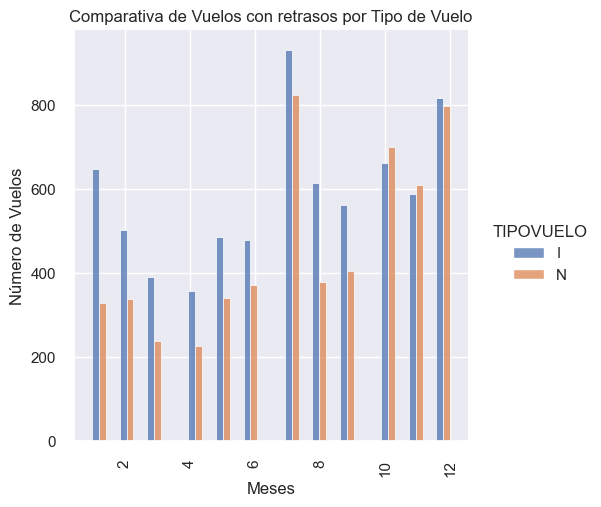

In [24]:
plt.figure(figsize = (10,6))
sns.set(style="darkgrid")

sns.displot(
    df[ ( ( ( df['Fecha-O'] - df['Fecha-I'] ).dt.total_seconds() / 60 ) > 15 ) ], 
    x='MES', 
    hue='TIPOVUELO', 
    multiple="dodge"
)

plt.title('Comparativa de Vuelos con retrasos por Tipo de Vuelo')
plt.ylabel('Número de Vuelos', fontsize=12)
plt.xlabel('Meses', fontsize=12)
plt.xticks(rotation=90)
plt.show()

- Figura 2: Se grafica la comparativa de los vuelos nacionales e internacionales que no presentan atraso ( que la diferencia de minutos entre campo 'Fecha-O' y 'Fecha-I' sea menor o igual a 15 min ).

<Figure size 1000x600 with 0 Axes>

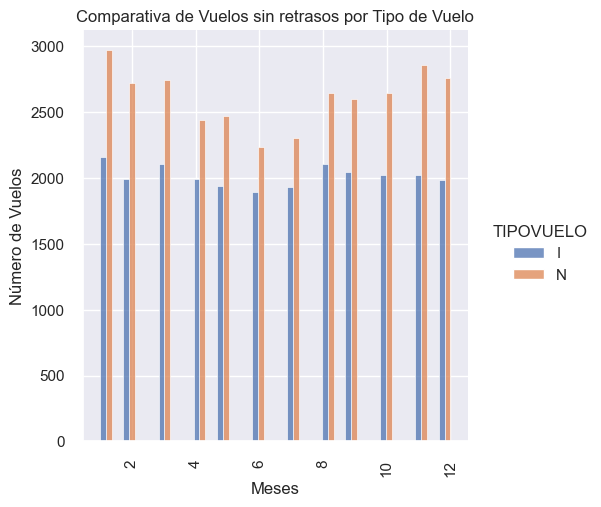

In [25]:
plt.figure(figsize = (10,6))
sns.set(style="darkgrid")

sns.displot(
    df[ ( ( ( df['Fecha-O'] - df['Fecha-I'] ).dt.total_seconds() / 60 ) <= 15 ) ], 
    x='MES', 
    hue='TIPOVUELO', 
    multiple="dodge"
)

plt.title('Comparativa de Vuelos sin retrasos por Tipo de Vuelo')
plt.ylabel('Número de Vuelos', fontsize=12)
plt.xlabel('Meses', fontsize=12)
plt.xticks(rotation=90)
plt.show()

- Figura 3: Se grafica el total de vuelos con atrasos por sobre el total de vuelos programados por cada mes.

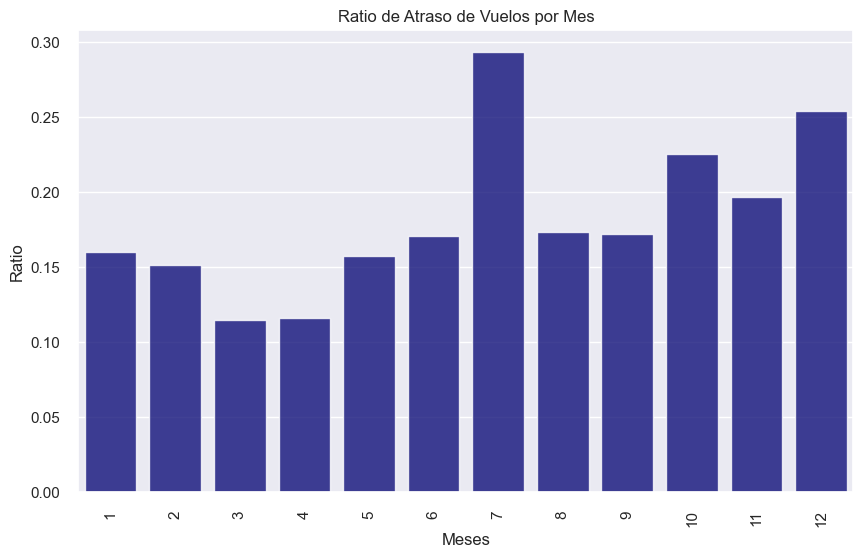

In [26]:
df_avg = pd.DataFrame()
df_avg['MES'] = df['MES'].drop_duplicates().values
df_avg['CANT_MES'] = df.groupby(['MES']).count()['Fecha-I'].values
df_avg['CANT_MES_ATRASO'] = df[ ( ( ( df['Fecha-O'] - df['Fecha-I'] ).dt.total_seconds() / 60 ) > 15 ) ].groupby(['MES']).count()['Fecha-I'].values
df_avg['RATIO_ATRASO'] = df_avg['CANT_MES_ATRASO'] / df_avg['CANT_MES']

plt.figure(figsize = (10,6))
sns.set(style="darkgrid")

sns.barplot(df_avg, x='MES', y = 'RATIO_ATRASO', color = 'darkblue', alpha=0.8)

plt.title('Ratio de Atraso de Vuelos por Mes')
plt.ylabel('Ratio', fontsize=12)
plt.xlabel('Meses', fontsize=12)
plt.xticks(rotation=90)
plt.show()

- Figura 4: Se grafica el total de vuelos con atrasos para viajes nacionales agrupados por empresa

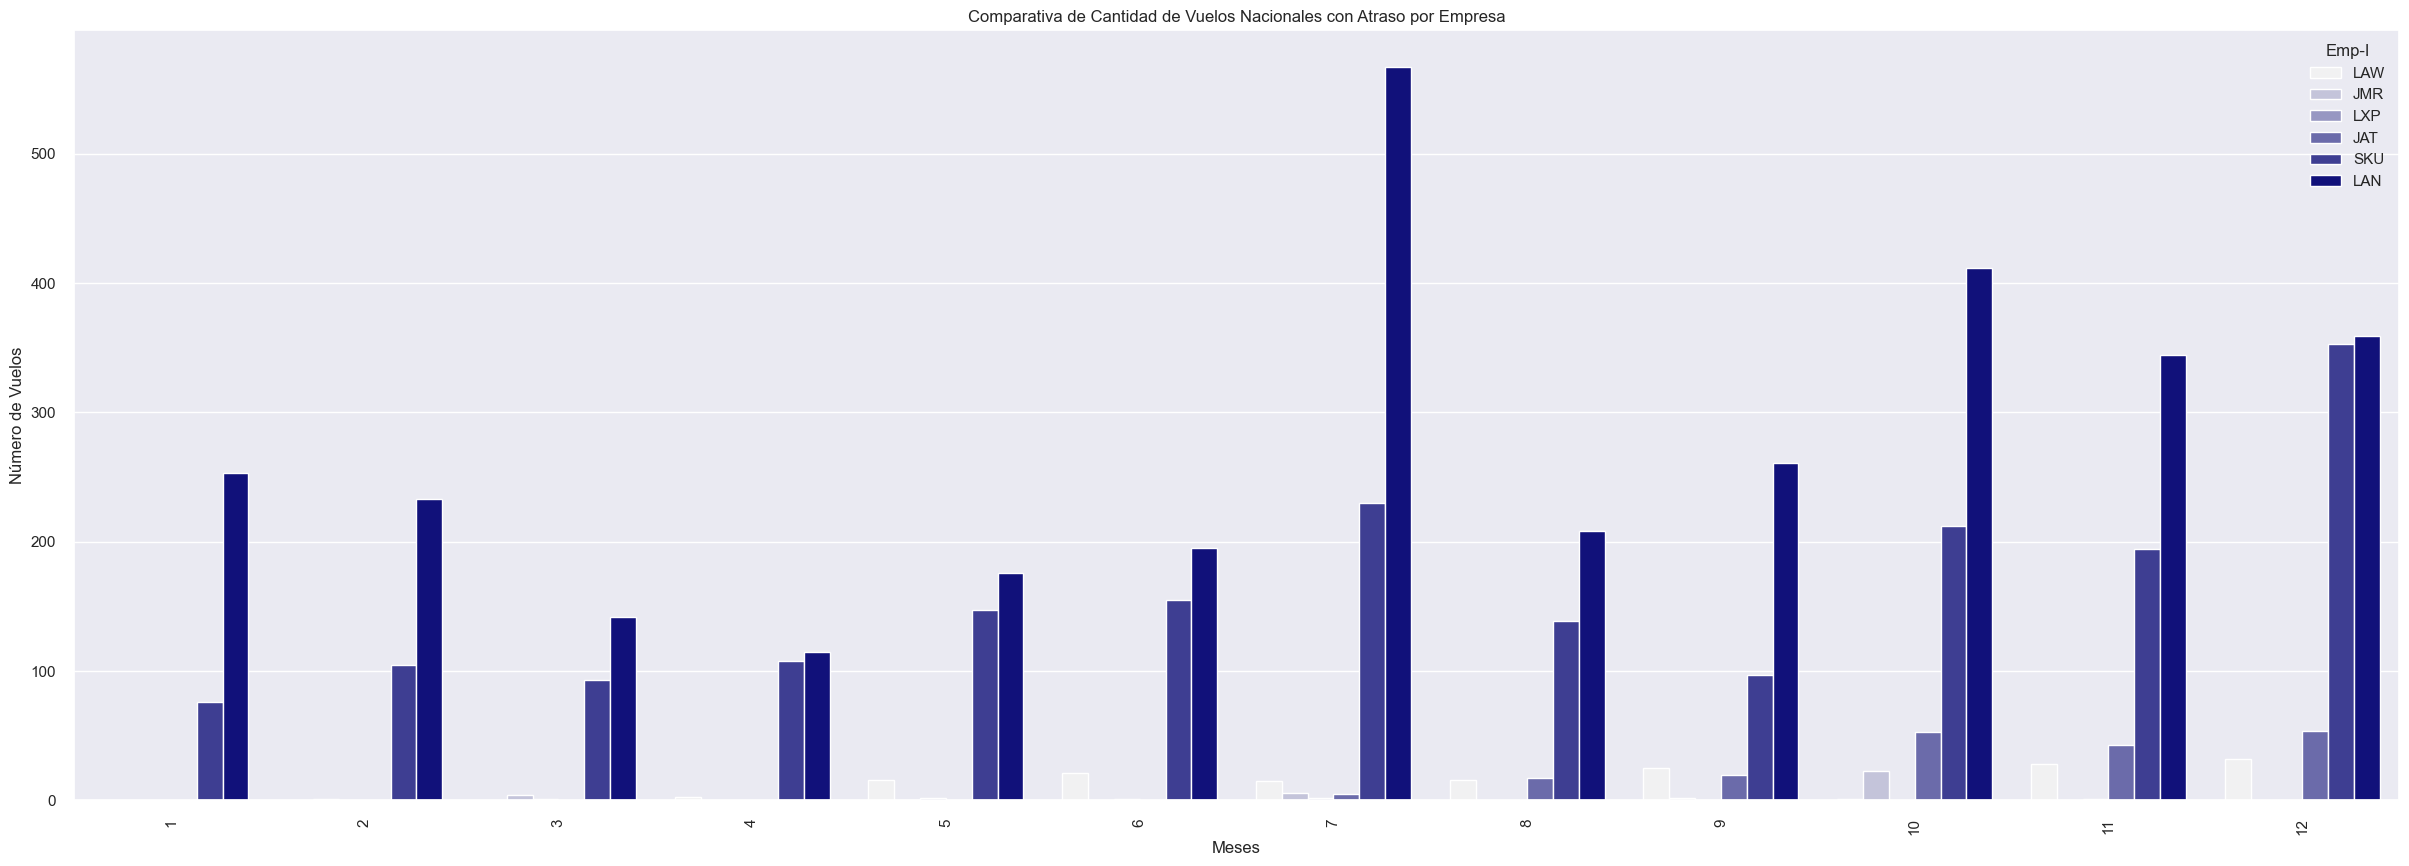

In [27]:
plt.figure(figsize = (30,10))
sns.set(style="darkgrid")

df_avg = pd.DataFrame( 
    df[ 
        ( df['TIPOVUELO'] == 'N' ) &
        ( ( ( df['Fecha-O'] - df['Fecha-I'] ).dt.total_seconds() / 60 ) > 15 )
    ].groupby(['MES','Emp-I'], as_index=False).count()[ ['MES','Emp-I','Fecha-I'] ].sort_values(by='Fecha-I') 
)

sns.barplot(
    data = df_avg, 
    x='MES',
    y = 'Fecha-I',
    hue='Emp-I',
    color = 'darkblue'
)

plt.title('Comparativa de Cantidad de Vuelos Nacionales con Atraso por Empresa')
plt.ylabel('Número de Vuelos', fontsize=12)
plt.xlabel('Meses', fontsize=12)
plt.xticks(rotation=90)
plt.show()

- Figura 5: Se grafica el total de vuelos con atrasos para viajes internacionales agrupados por empresa (se toma como muestra el mes de enero)

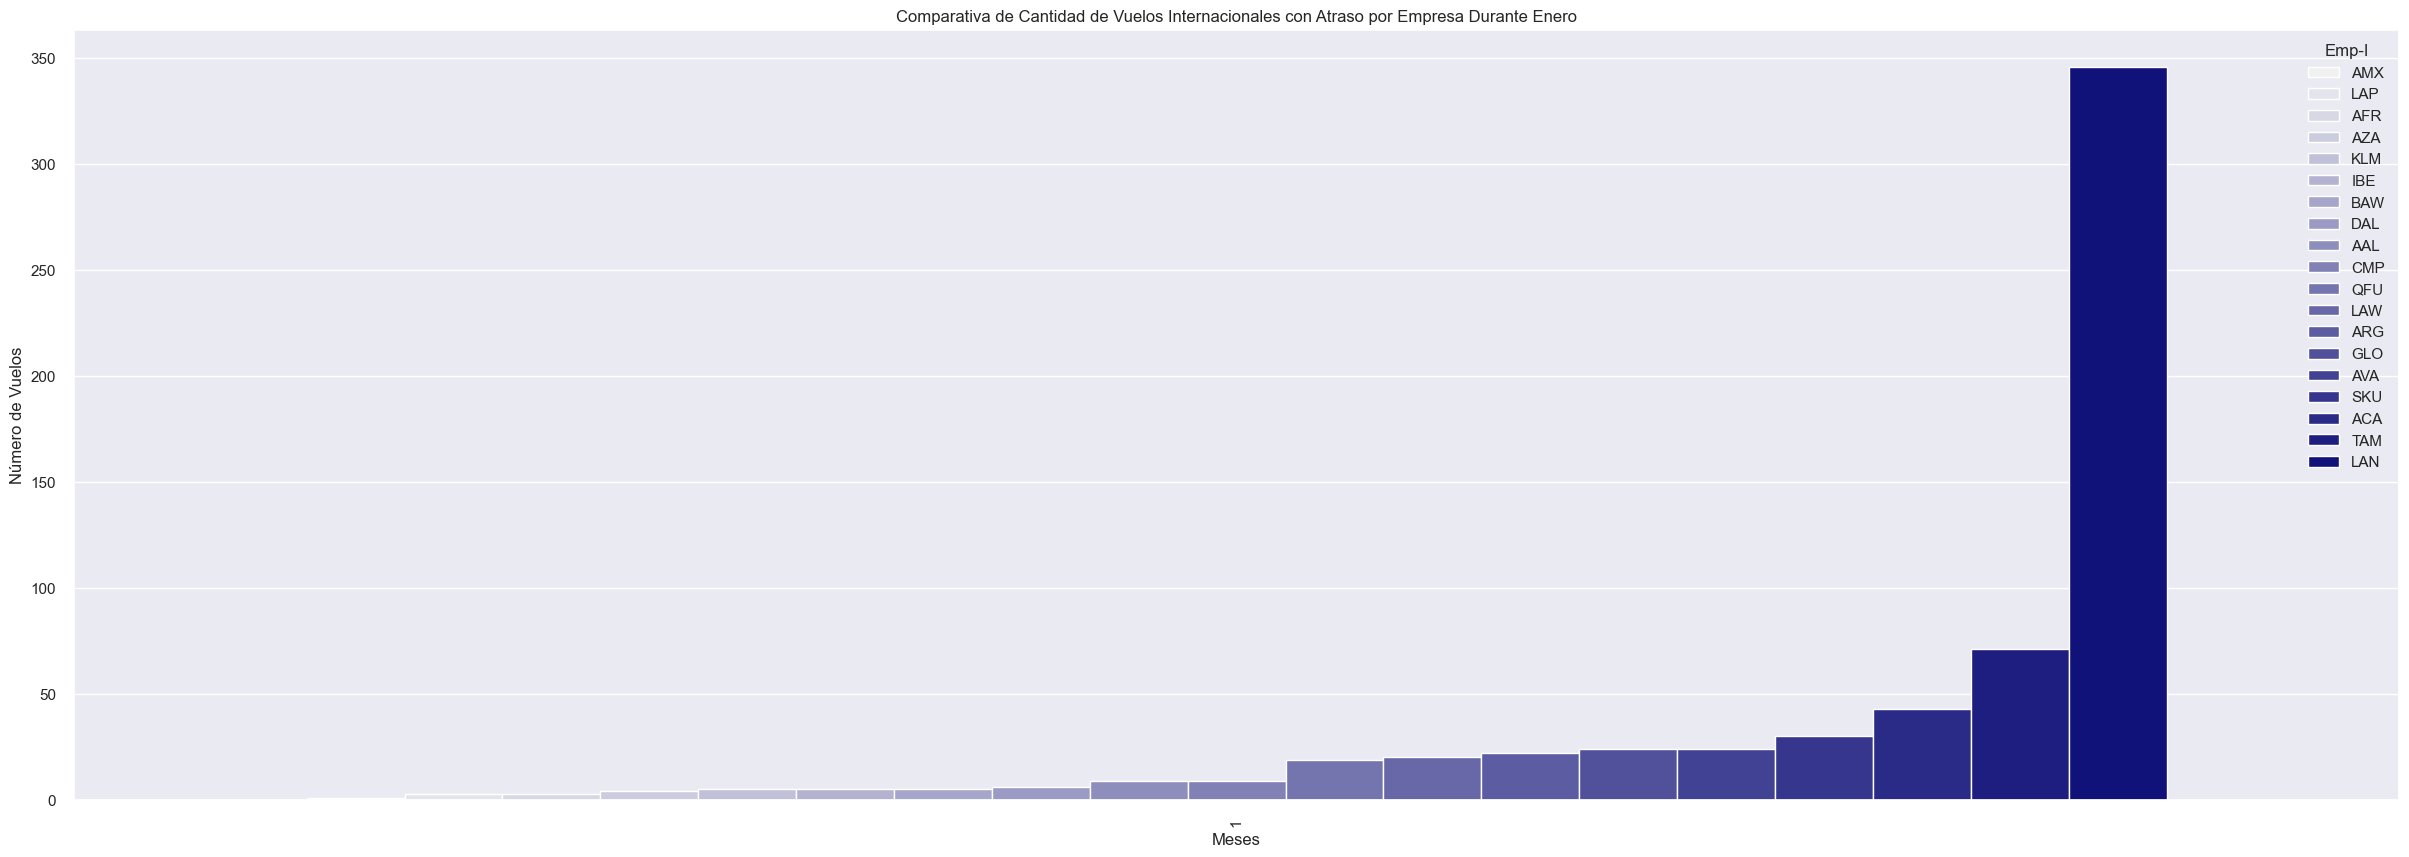

In [28]:
plt.figure(figsize = (30,10))
sns.set(style="darkgrid")

df_avg = pd.DataFrame( 
    df[ 
        ( df['TIPOVUELO'] == 'I' ) &
        ( ( ( df['Fecha-O'] - df['Fecha-I'] ).dt.total_seconds() / 60 ) > 15 ) &
        ( df['MES'] == 1 )
    ].groupby(['MES','Emp-I'], as_index=False).count()[ ['MES','Emp-I','Fecha-I'] ].sort_values(by='Fecha-I')
)

sns.barplot(
    data = df_avg, 
    x='MES',
    y = 'Fecha-I',
    hue='Emp-I',
    color = 'darkblue'
)

plt.title('Comparativa de Cantidad de Vuelos Internacionales con Atraso por Empresa Durante Enero')
plt.ylabel('Número de Vuelos', fontsize=12)
plt.xlabel('Meses', fontsize=12)
plt.xticks(rotation=90)
plt.show()

- Figura 6: Se grafica el total de vuelos con atrasos para viajes nacionales agrupados por el destino de cada uno de los vuelos

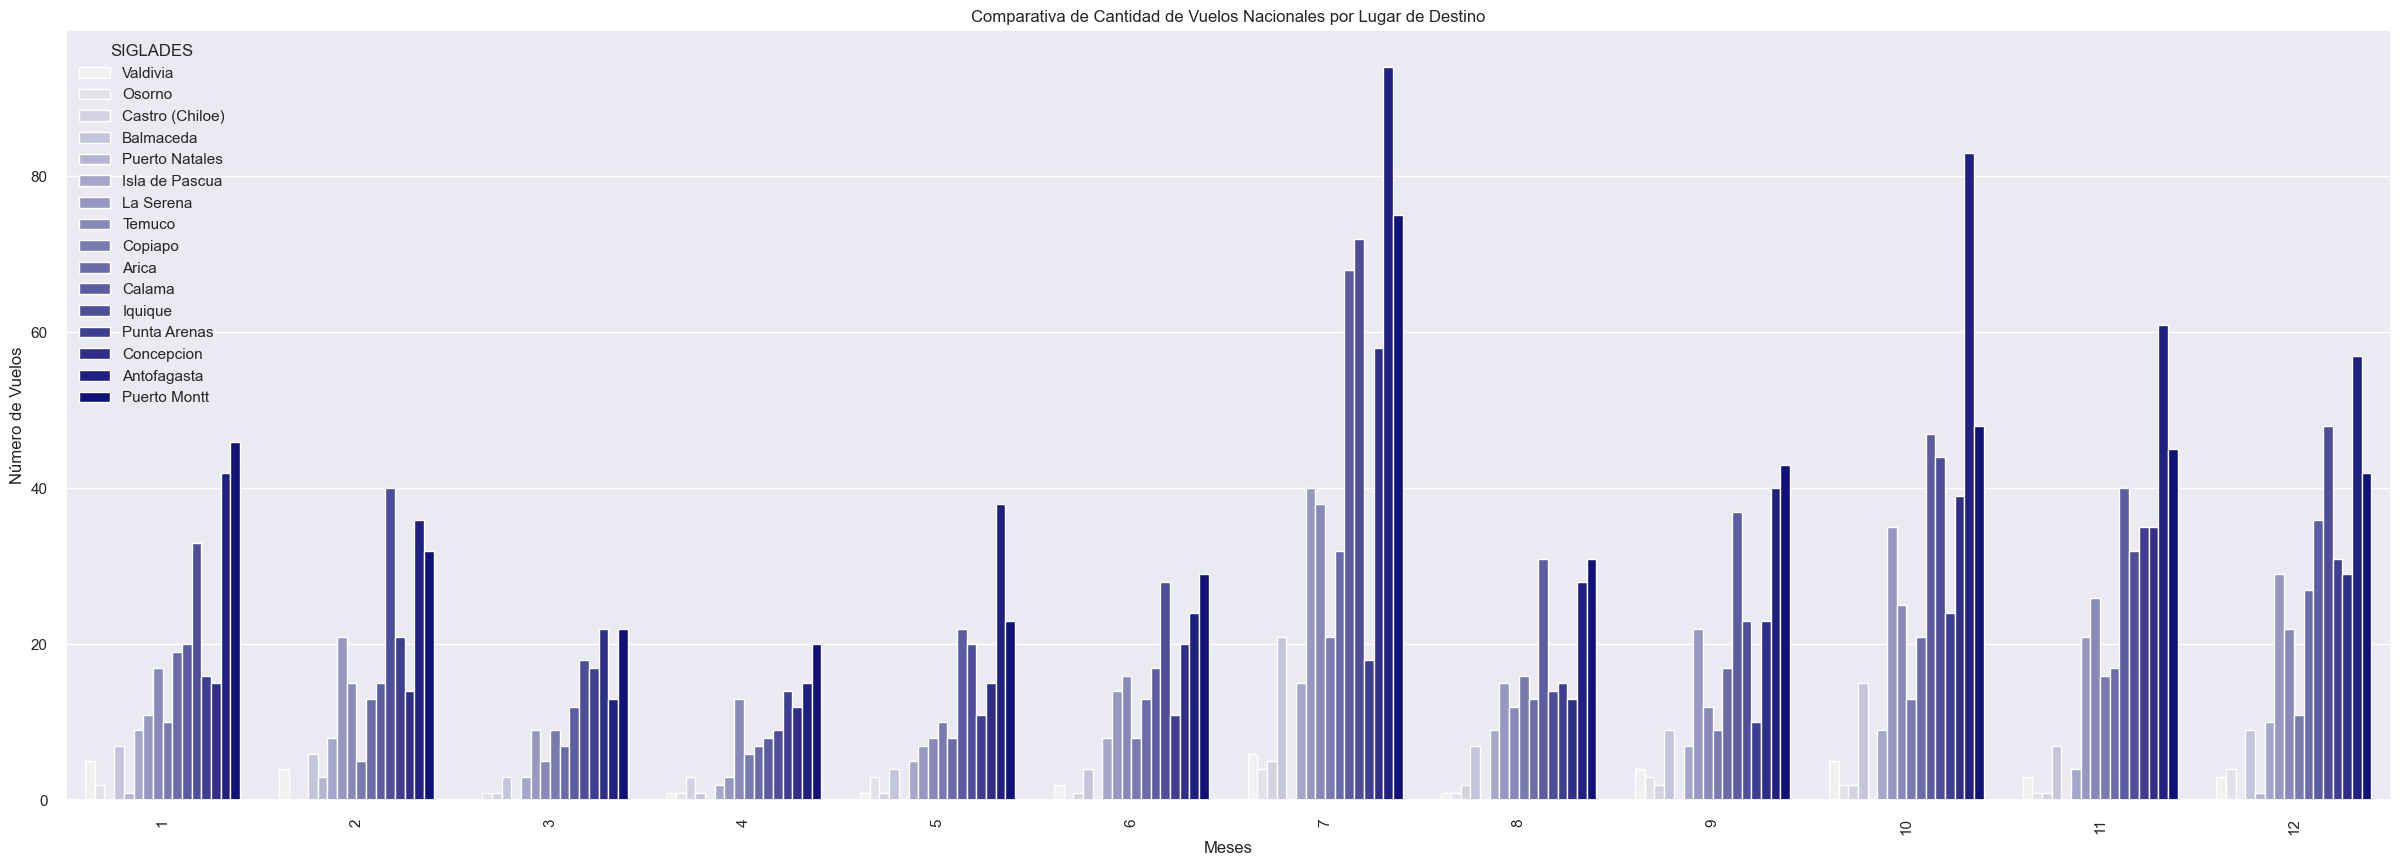

In [29]:
plt.figure(figsize = (30,10))
sns.set(style="darkgrid")

df_avg = pd.DataFrame( 
    df[ 
        ( df['TIPOVUELO'] == 'N' ) &
        ( ( ( df['Fecha-O'] - df['Fecha-I'] ).dt.total_seconds() / 60 ) > 15 ) & 
        ( df['Emp-I']=='LAN' )
    ].groupby(['MES','SIGLADES'], as_index=False).count()[ ['MES','SIGLADES','Fecha-I'] ].sort_values(by='Fecha-I') 
)

sns.barplot(
    data = df_avg, 
    x='MES',
    y = 'Fecha-I',
    hue='SIGLADES',
    color = 'darkblue'
)

plt.title('Comparativa de Cantidad de Vuelos Nacionales por Lugar de Destino')
plt.ylabel('Número de Vuelos', fontsize=12)
plt.xlabel('Meses', fontsize=12)
plt.xticks(rotation=90)
plt.show()

- Figura 7: Se grafica el Número de días en que la precipitación diaria supera 10 mm.

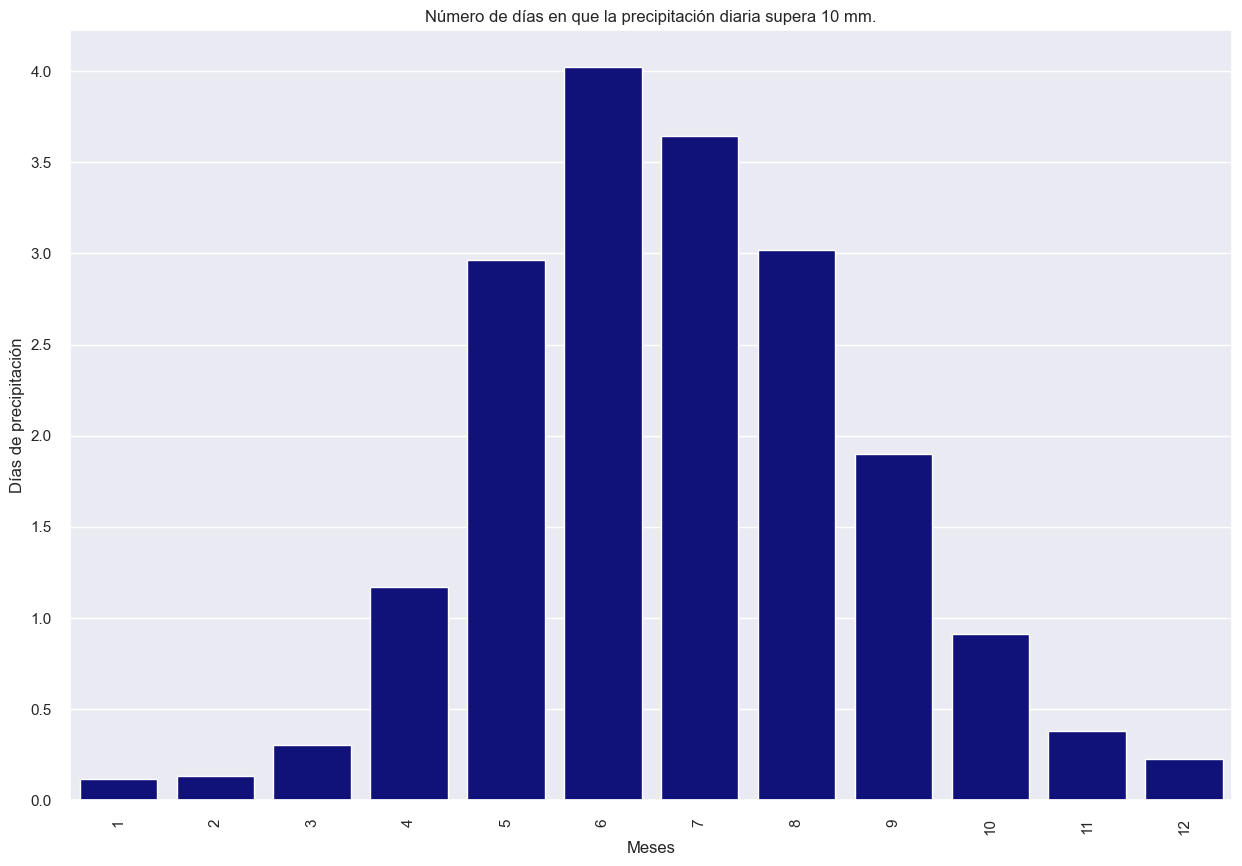

In [30]:
l_col = df_nhpd.columns.values.tolist()
l_col.remove('number_of_heavy_precipitation_days')

sns.barplot(
    data = df_nhpd[ df_nhpd['CODIGO']=='SCEL' ][ l_col ],
    color = 'darkblue'
)

plt.title('Número de días en que la precipitación diaria supera 10 mm.')
plt.ylabel('Días de precipitación', fontsize=12)
plt.xlabel('Meses', fontsize=12)
plt.xticks(rotation=90)
plt.show()

- Figura 8: Se grafica el Número de días en que la precipitación diaria supera 20 mm.

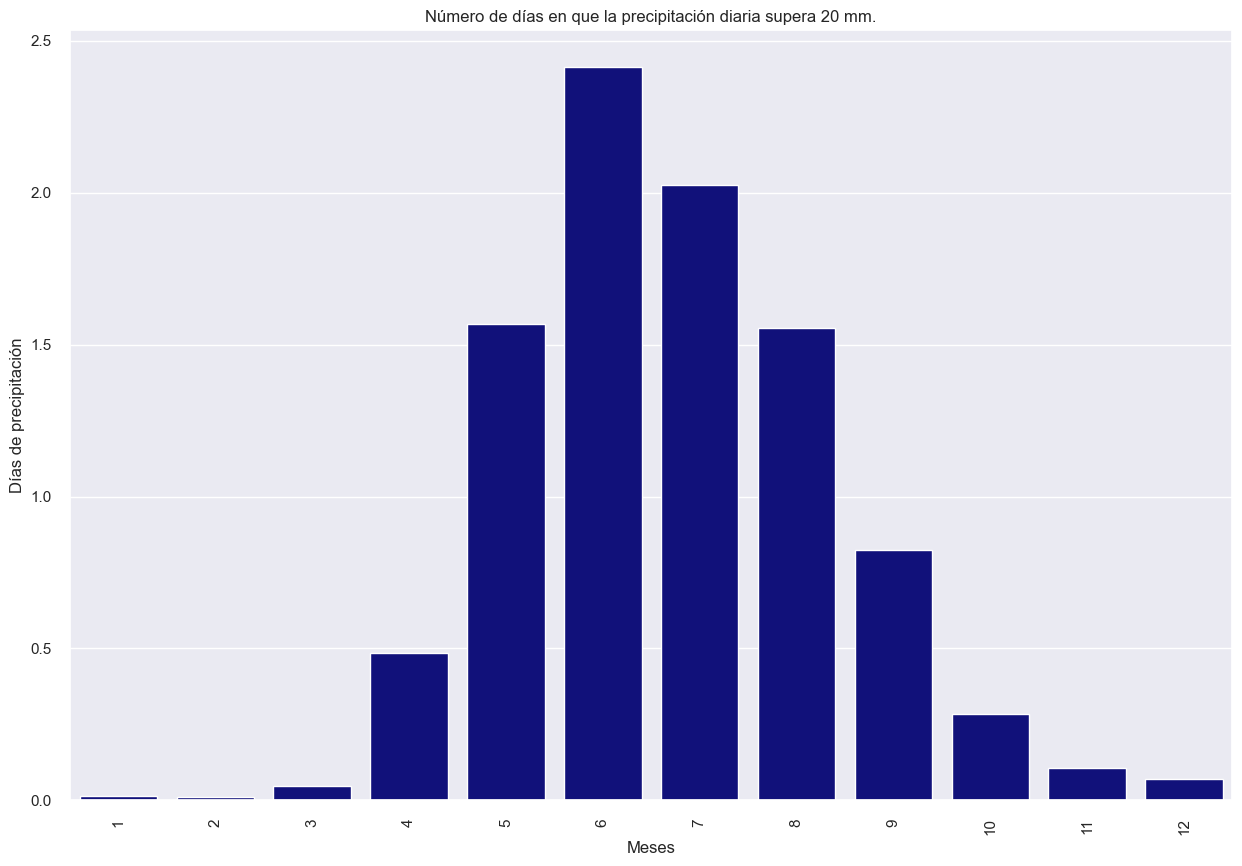

In [31]:
l_col = df_nvhpd.columns.values.tolist()
l_col.remove('number_of_very_heavy_precipitation_days')

sns.barplot(
    data = df_nvhpd[ df_nvhpd['CODIGO']=='SCEL' ][ l_col ],
    color = 'darkblue'
)

plt.title('Número de días en que la precipitación diaria supera 20 mm.')
plt.ylabel('Días de precipitación', fontsize=12)
plt.xlabel('Meses', fontsize=12)
plt.xticks(rotation=90)
plt.show()

- Figura 9: Se grafica el Valor medio del máximo diario de la magnitud del viento (m/s).

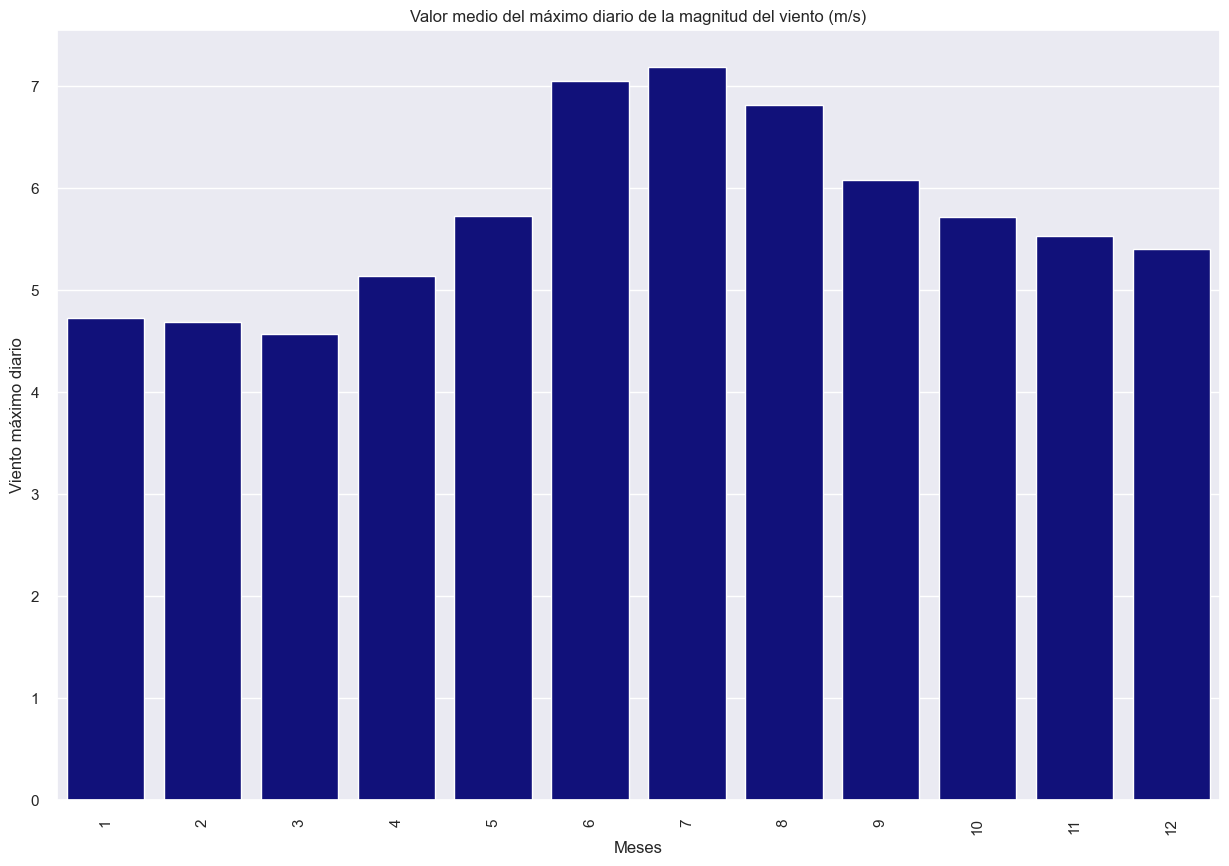

In [32]:
l_col = df_vel_max.columns.values.tolist()
l_col.remove('vel_max')

sns.barplot(
    data = df_vel_max[ df_vel_max['CODIGO']=='SCEL' ][ l_col ],
    color = 'darkblue'
)

plt.title('Valor medio del máximo diario de la magnitud del viento (m/s)')
plt.ylabel('Viento máximo diario', fontsize=12)
plt.xlabel('Meses', fontsize=12)
plt.xticks(rotation=90)
plt.show()

A partir a los análisis realizados se puede determinar que existe un cierto patrón en el comportamiento de los vuelos que registran un atraso del cual se puede inferir lo siguiente:

- Las aerolíneas que concentra una mayor cantidad de vuelos tanto para viajes Nacionales como Internacionales correspondería a Grupo LATAM. A partir de lo anterior se puede visualizar que la alta demanda puede traer consigo un mayor número de casos en los que el vuelo presenta un retraso. 
- Existe una mayor concentración de atrasos de vuelos durante el mes de Julio, lo cual puede estar relacionado a las condiciones meteorológicas, las cuales pueden dificultar las operaciones de despegue de un vuelo
- Durante los mes de enero, julio y diciembre se registró un peak de atrasos en los vuelos para viajes internacionales. Respecto a lo anterior se puede visualizar que en estos meses se registra tambien la menor cantidad de vuelos que despegan a la hora, lo cual puede estar relacionado principalmente a una mayor demanda de estos vuelos por ser temporada alta y para el caso de julio podría estar relacionado a las condiciones meteorológicas del mes
- Existe una mayor demanda de los vuelos nacionales con destino hacia la zona norte, lo cual a su vez visualiza una alta cantidad de vuelos con atrasos.

### 2. Genera las columnas adicionales y luego expórtelas en un archivo synthetic_features.csv :

- **Retraso_min**: diferencia en minutos entre **Fecha-O** y **Fecha-I** .

In [33]:
df['Retraso_min'] = (df['Fecha-O'] - df['Fecha-I'] ).dt.total_seconds() / 60

- **Rango_Temperatura:** Valor medio de la amplitud térmica diaria (Tmax - Tmin).

In [34]:
l_col = df.columns.values.tolist()
l_col.append(10)

df = pd.merge(
    df,
    df_dtr[ df_dtr['CODIGO']=='SCEL' ].T.reset_index(drop=False),
    left_on='MES',
    right_on='index'
)[l_col]

df = df.rename(columns={10:'Rango_Temperatura'})

- **Viento_Maximo:** Valor medio del máximo diario de la magnitud del viento (m/s).

In [35]:
l_col = df.columns.values.tolist()
l_col.append(10)

df = pd.merge(
    df,
    df_vel_max[ df_vel_max['CODIGO']=='SCEL' ].T.reset_index(drop=False),
    left_on='MES',
    right_on='index'
)[l_col]

df = df.rename(columns={10:'Viento_Maximo'})

- **Precipitaciones_Altas:** Número de días en que la precipitación diaria supera 10 mm.

In [36]:
l_col = df.columns.values.tolist()
l_col.append(10)

df = pd.merge(
    df,
    df_nhpd[ df_nhpd['CODIGO']=='SCEL' ].T.reset_index(drop=False),
    left_on='MES',
    right_on='index'
)[l_col]

df = df.rename(columns={10:'Precipitaciones_Altas'})

- **Precipitaciones_Muy_Altas:** Número de días en que la precipitación diaria supera 20 mm.

In [37]:
l_col = df.columns.values.tolist()
l_col.append(10)

df = pd.merge(
    df,
    df_nvhpd[ df_nvhpd['CODIGO']=='SCEL' ].T.reset_index(drop=False),
    left_on='MES',
    right_on='index'
)[l_col]

df = df.rename(columns={10:'Precipitaciones_Muy_Altas'})

- **Distancia_millas:** distancia en millas desde la ciudad de origen al destino
- **Destino_Sentido:** Rumbo magnético (dirección en relación con el norte magnético)
- **Destino_Coordenada:** Coordenada Rumbo magnético (dirección en relación con el norte magnético)
- **Inicio_Sentido:** Rumbo verdadero (dirección relativa al norte verdadero, o el polo norte geográfico)
- **Inicio_Coordenada:** Coordenada Rumbo verdadero (dirección relativa al norte verdadero, o el polo norte geográfico)

In [38]:
l_col = df.columns.values.tolist() 

l_col += [
    'Distancia_millas',
    'latitud_grados',
    'latitud_minutos',
    'latitud_segundos',
    'latitud',
    'longitud_grados',
    'longitud_minutos',
    'longitud_segundos',
    'longitud',
    'Destino_Sentido',
    'Destino_Coordenada',
    'Inicio_Coordenada',
    'Inicio_Sentido'
]

df = pd.merge(
    df,
    df_dist,
    left_on=['Ori-I','Des-O'],
    right_on=['Codigo_Origen','Codigo_Destino']
)[l_col].drop_duplicates()

- **Cantidad_Vuelos_Dia:** Cantidad de vuelos programados el mismo día según campo Fecha-I

In [39]:
l_col = df.columns.values.tolist()
l_col.append('Cantidad_Vuelos_Dia')

df = pd.merge(
    df,
    df.groupby(['MES','AÑO','DIA','TIPOVUELO'], as_index=False).count()[['MES','AÑO','DIA','TIPOVUELO','Fecha-I']].rename(columns={'Fecha-I':'Cantidad_Vuelos_Dia'}),
    left_on=['MES','AÑO','DIA','TIPOVUELO'],
    right_on=['MES','AÑO','DIA','TIPOVUELO']
)[l_col].drop_duplicates()

- **Hora_Vuelo**: retorna la hora en la que se programó inicialmente el vuelo

In [40]:
df['Hora_Vuelo'] = df['Fecha-I'].dt.hour

- **Cantidad_Vuelos_Hora:** Cantidad de vuelos programados a la misma hora durante el mismo día

In [41]:
l_col = df.columns.values.tolist()
l_col.append('Cantidad_Vuelos_Hora')

df = pd.merge(
    df,
    df.groupby(['MES','AÑO','DIA','Hora_Vuelo','TIPOVUELO'], as_index=False).count()[['MES','AÑO','DIA','Hora_Vuelo','TIPOVUELO','Fecha-I']].rename(columns={'Fecha-I':'Cantidad_Vuelos_Hora'}),
    left_on=['MES','AÑO','DIA','Hora_Vuelo','TIPOVUELO'],
    right_on=['MES','AÑO','DIA','Hora_Vuelo','TIPOVUELO']
)[l_col].drop_duplicates()

- **Cantidad_Vuelos_Destino:** Cantidad de vuelos programados en un mismo día hacia el mismo destino

In [42]:
l_col = df.columns.values.tolist()
l_col.append('Cantidad_Vuelos_Destino')

df = pd.merge(
    df,
    df.groupby(['MES','AÑO','DIA','Des-O'], as_index=False).count()[['MES','AÑO','DIA','Des-O','Fecha-I']].rename(columns={'Fecha-I':'Cantidad_Vuelos_Destino'}),
    left_on=['MES','AÑO','DIA','Des-O'],
    right_on=['MES','AÑO','DIA','Des-O']
)[l_col].drop_duplicates()

- **Cantidad_Vuelos_Opera:** Cantidad de vuelos programados en un mismo día por una misma aerolínea 

In [43]:
l_col = df.columns.values.tolist()
l_col.append('Cantidad_Vuelos_Opera')

df = pd.merge(
    df,
    df.groupby(['MES','AÑO','DIA','OPERA'], as_index=False).count()[['MES','AÑO','DIA','OPERA','Fecha-I']].rename(columns={'Fecha-I':'Cantidad_Vuelos_Opera'}),
    left_on=['MES','AÑO','DIA','OPERA'],
    right_on=['MES','AÑO','DIA','OPERA']
)[l_col].drop_duplicates()

- **Dif_sig_vuelo:** Calcula la cantidad de minutos en los cuales se realizará el siguiente vuelo 

In [44]:
l_exp = []

for tip in ['I','N']:
    
    l_piv = df[ df['TIPOVUELO'] == tip ]['Fecha-I'].sort_values().values

    for i in range(len(l_piv)):

        d = { 'Fecha-I' : l_piv[i], 'TIPOVUELO' : tip }

        if (i+1) < len(l_piv):
            d['Dif_sig_vuelo'] = (l_piv[i+1] - l_piv[i])/np.timedelta64(1, 'm')
        else:
            d['Dif_sig_vuelo'] = 0
        
        l_exp.append(d)

df_piv = pd.DataFrame(l_exp)

l_col = df.columns.values.tolist()
l_col.append('Dif_sig_vuelo')

df = pd.merge(
    df,
    df_piv,
    left_on=['Fecha-I','TIPOVUELO'],
    right_on=['Fecha-I','TIPOVUELO']
)[l_col].drop_duplicates()

- **Vuelos_Acum_Hora:** Calcula el total de vuelos ya realizados por cada hora.

In [45]:
df_resul = pd.DataFrame()

df_piv = df[['Hora_Vuelo','TIPOVUELO','MES','DIA','AÑO','Cantidad_Vuelos_Hora']].drop_duplicates()

for i in range(1,25):
    df_piv2 = df_piv[ df_piv['Hora_Vuelo'] < i ].groupby(['TIPOVUELO','MES','DIA','AÑO'], as_index=False).sum()[['TIPOVUELO','MES','DIA','AÑO','Cantidad_Vuelos_Hora']]

    df_piv2['Hora_Vuelo'] = i

    df_resul = pd.concat([ df_resul, df_piv2 ])

df_resul = df_resul.rename(columns={'Cantidad_Vuelos_Hora':'Vuelos_Acum_Hora'})

l_col = df.columns.values.tolist()
l_col.append('Vuelos_Acum_Hora')

df = pd.merge(
    df,
    df_resul,
    left_on=['Hora_Vuelo','TIPOVUELO','MES','DIA','AÑO'],
    right_on=['Hora_Vuelo','TIPOVUELO','MES','DIA','AÑO']
)[l_col].drop_duplicates()

df.loc[ df['Vuelos_Acum_Hora'].isna() ] = 0

- **Penalizacion_Viento:** Se calcula una penalización por riesgo respecto a las condiciones climáticas. A medida que pasan las horas puede existir una mayor probabilidad que un vuelo presente un atraso en el caso que las condiciones climáticas no son favorables. 

In [46]:
df['Penalizacion_Viento'] = ( df['Vuelos_Acum_Hora'] / df['Cantidad_Vuelos_Dia'] ) * ( df['Viento_Maximo'] / df['Viento_Maximo'].max() )

- **Penalizacion_Precipitaciones:** Se calcula una penalización por riesgo respecto a las condiciones climáticas. A medida que pasan las horas puede existir una mayor probabilidad que un vuelo presente un atraso en el caso que las condiciones climáticas no son favorables. 

In [47]:
df['Penalizacion_Precipitaciones'] = ( df['Vuelos_Acum_Hora'] / df['Cantidad_Vuelos_Dia'] ) * ( df['Precipitaciones_Muy_Altas'] / df['Precipitaciones_Muy_Altas'].max() )

- **Atraso:** Se considera como atraso a todos aquellos vuelos cuyo retraso en minutos sea mayor a 15 min.

In [48]:
df[ 'Atraso' ] = np.where( df['Retraso_min'] > 15, 1, 0 )

- **Dia_Semana:** Se genera campo con información respecto al día de la semana en el cual se programó el vuelo

In [49]:
df['Fecha-I'] = df['Fecha-I'].astype('datetime64[ns]')
df['Fecha-O'] = df['Fecha-O'].astype('datetime64[ns]')

In [50]:
df['Dia_Semana'] = df['Fecha-I'].dt.day_name()

**Temporada:** Se genera campo con información respecto a si el vuelo fue programado en temporada alta
- *(Fuente 1: https://www.chile.travel/blog/temporada-baja-chile-ventajas/#:~:text=De%20marzo%20a%20noviembre%20se,experiencia%20%C3%BAnica%20y%20m%C3%A1s%20econ%C3%B3mica. )*
- *(Fuente 2: https://www.conaset.cl/wp-content/uploads/2017/11/Informe-Nacional-Posterior-Fiestas-Patrias-2017.pdf )*
- *(Fuente 3: https://www.ayudamineduc.cl/sites/default/files/cuadrocalendarioescolarregional2017.pdf )*

In [51]:
df['Temporada'] = ''

df.loc[ df['Fecha-I'].between('2017-03-01','2017-12-01'), 'Temporada' ] = 'Temporada Baja'

df.loc[ ( df['Fecha-I'].between('2017-12-01','2018-01-31') ) , 'Temporada' ] = 'Temporada Alta' #Vacaciones de Verano 
df.loc[ ( df['Fecha-I'].between('2017-01-01','2017-03-31') ) , 'Temporada' ] = 'Temporada Alta' #Vacaciones de Verano 
df.loc[ ( df['Fecha-I'].between('2017-07-10','2017-07-28') ) , 'Temporada' ] = 'Temporada Alta' #Vacaciones de Invierno
df.loc[ ( df['Fecha-I'].between('2017-04-09','2017-04-15') ) , 'Temporada' ] = 'Temporada Alta' #Semana Santa
df.loc[ ( df['Fecha-I'].between('2017-09-11','2017-09-19') ) , 'Temporada' ] = 'Temporada Alta' #Fiestas Patrias

- Se exportan datos synthetic_features.csv

In [52]:
df[[
    'Distancia_millas',
    'latitud_grados',
    'latitud_minutos',
    'latitud_segundos',
    'latitud',
    'longitud_grados',
    'longitud_minutos',
    'longitud_segundos',
    'longitud',
    'Destino_Sentido',
    'Destino_Coordenada',
    'Inicio_Coordenada',
    'Inicio_Sentido',
    'Retraso_min', 
    'Rango_Temperatura',
    'Viento_Maximo',
    'Precipitaciones_Altas', 
    'Precipitaciones_Muy_Altas',
    'Distancia_millas', 
    'Cantidad_Vuelos_Dia', 
    'Hora_Vuelo',
    'Cantidad_Vuelos_Hora', 
    'Cantidad_Vuelos_Destino', 
    'Cantidad_Vuelos_Opera',
    'Dif_sig_vuelo',
    'Vuelos_Acum_Hora',
    'Penalizacion_Viento',
    'Penalizacion_Precipitaciones',
    'Atraso', 
    'Dia_Semana', 
    'Temporada'
]].to_csv('synthetic_features.csv', index = False)

### 3. ¿Cómo se compone la tasa de atraso por destino, aerolínea, mes del año, día de la semana, temporada, tipo de vuelo? ¿Qué variables esperarías que más influyeran en predecir atrasos?

**Función calcula_tasa_atraso**: Calcula la tasa de atrasos respecto al total de vuelos realizados de acuerdo a los campos pasados por parametro
- df: Dataset de origen
- df_avg: Dataset con datos claves agrupados y totalizados
- cols: Nombre de campos a partir de los cuales se desea calcular la tasa de atraso 

In [53]:
df_avg = df.groupby(
    ['Atraso','SIGLADES','OPERA','MES','Dia_Semana','Temporada','TIPOVUELO','Viento_Maximo','Precipitaciones_Altas','Precipitaciones_Muy_Altas','Distancia_millas','Hora_Vuelo','Cantidad_Vuelos_Dia','Rango_Temperatura','Cantidad_Vuelos_Hora'], 
    as_index=False
).count()[['Atraso','SIGLADES','OPERA','MES','Dia_Semana','Temporada','TIPOVUELO','Viento_Maximo','Precipitaciones_Altas','Precipitaciones_Muy_Altas','Distancia_millas','Hora_Vuelo','Cantidad_Vuelos_Dia','Rango_Temperatura', 'Cantidad_Vuelos_Hora','Fecha-I']].rename(columns={'Fecha-I':'Total'})

In [54]:
def calcula_tasa_atraso( df, df_avg, cols ):

    l1 = copy.copy(cols)
    l2 = copy.copy(cols)

    l1.append('Atraso')
    l2.append('Total')

    df_piv = pd.merge(
        df.groupby(cols, as_index=False).sum()[ l1 ],
        df_avg.groupby(cols, as_index=False).sum()[ l2 ],
        left_on = cols,
        right_on = cols
    )
    
    df_piv['Tasa'] = df_piv['Atraso'] / df_piv['Total']

    return df_piv

<Figure size 6000x6000 with 0 Axes>

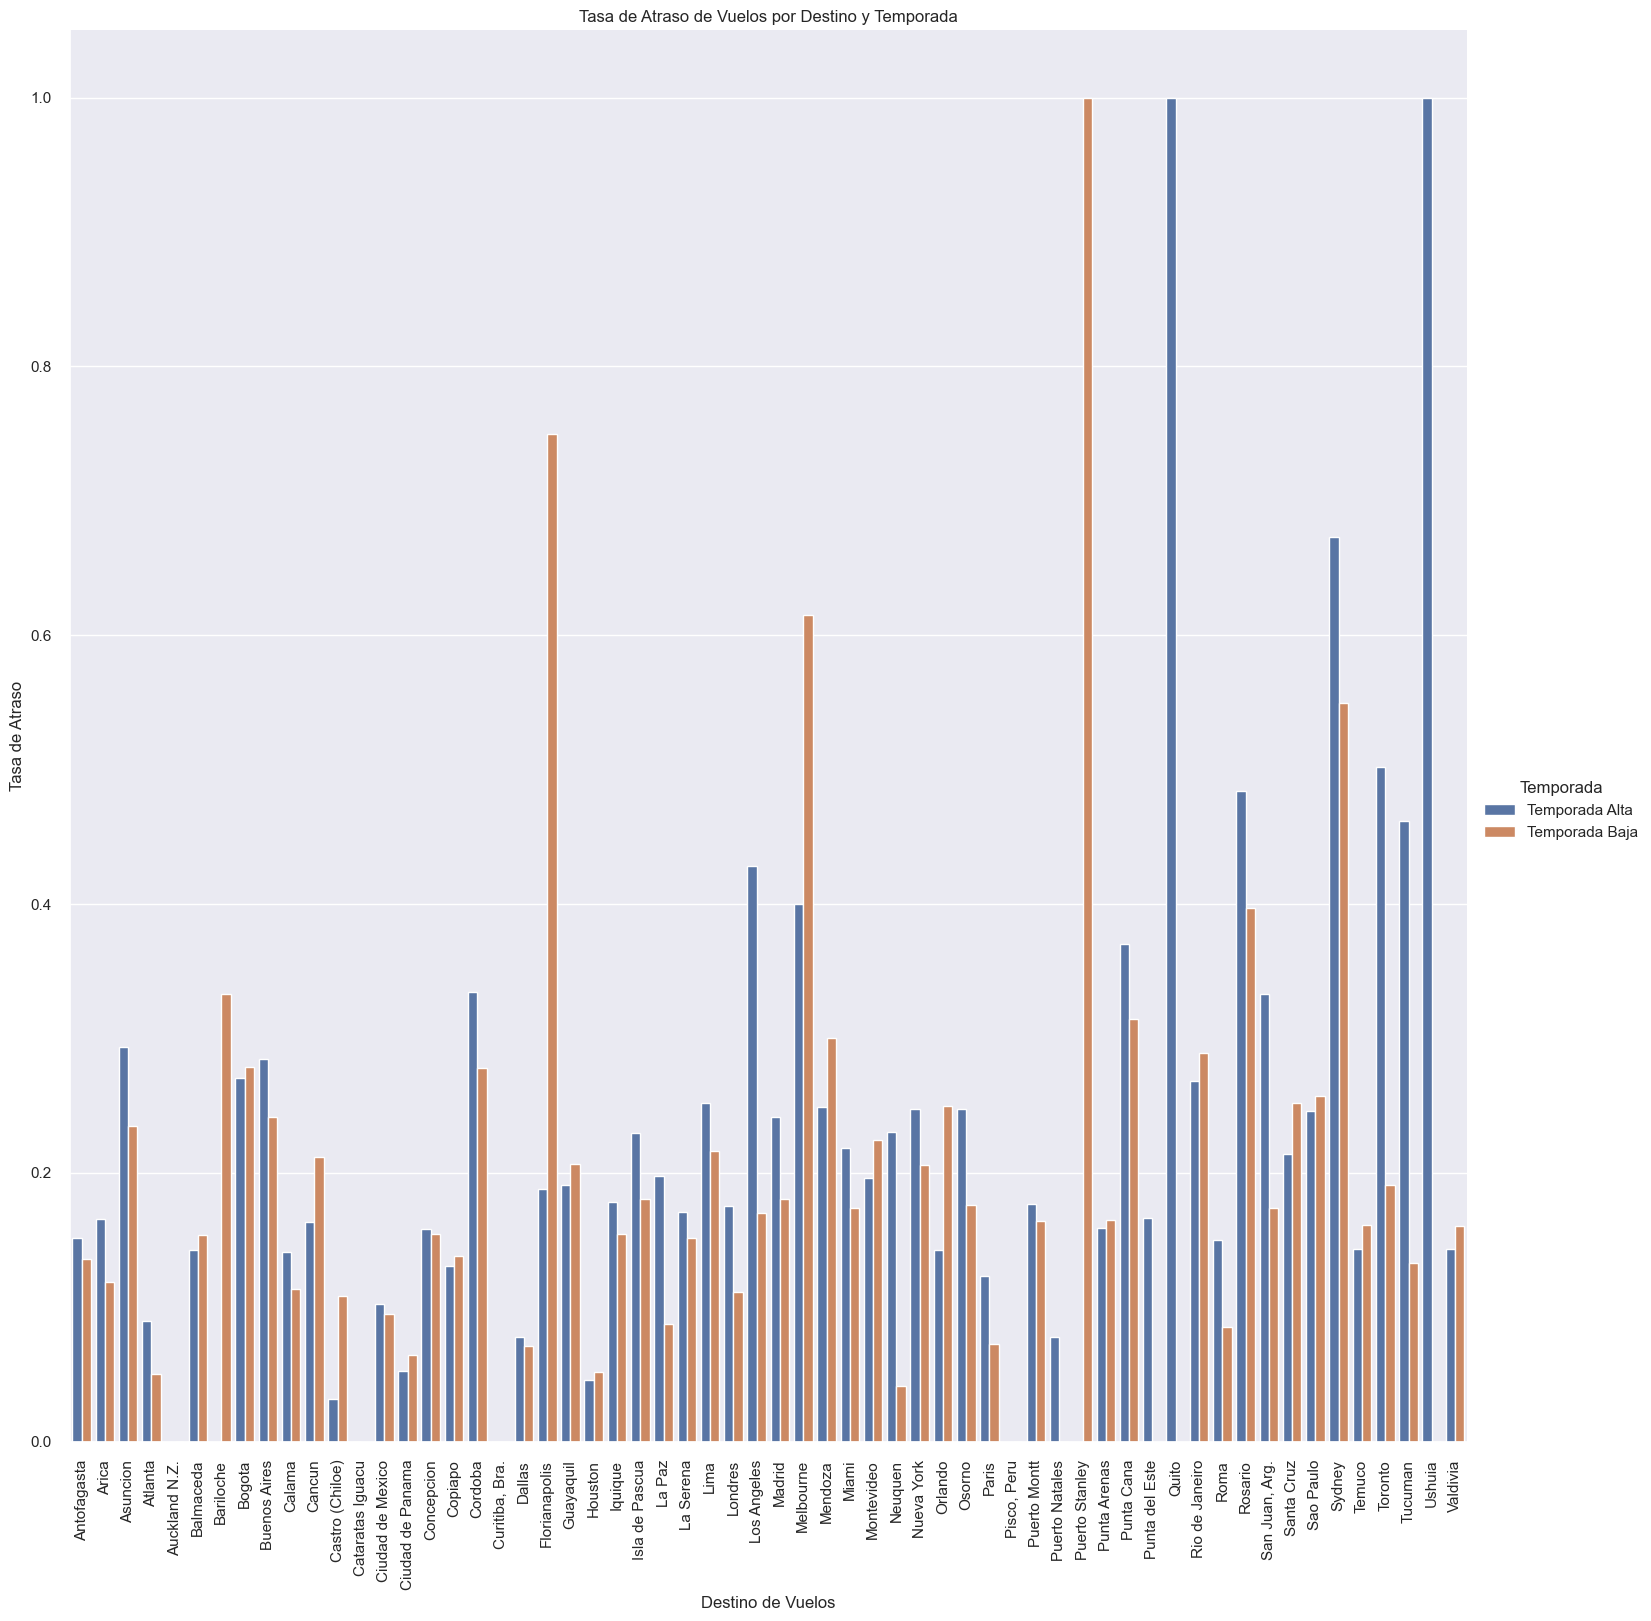

In [55]:
df_piv = calcula_tasa_atraso( df, df_avg, ['SIGLADES','Temporada'] )


plt.figure(figsize = (60,60))
sns.set(style="darkgrid")

sns.catplot(
    data = df_piv[['SIGLADES','Temporada','Tasa']], 
    x='SIGLADES', 
    y = 'Tasa',
    hue = 'Temporada', 
    kind ='bar',
    height = 15
)

plt.title('Tasa de Atraso de Vuelos por Destino y Temporada')
plt.ylabel('Tasa de Atraso', fontsize=12)
plt.xlabel('Destino de Vuelos', fontsize=12)
plt.xticks(rotation=90)
plt.show()

<Figure size 6000x6000 with 0 Axes>

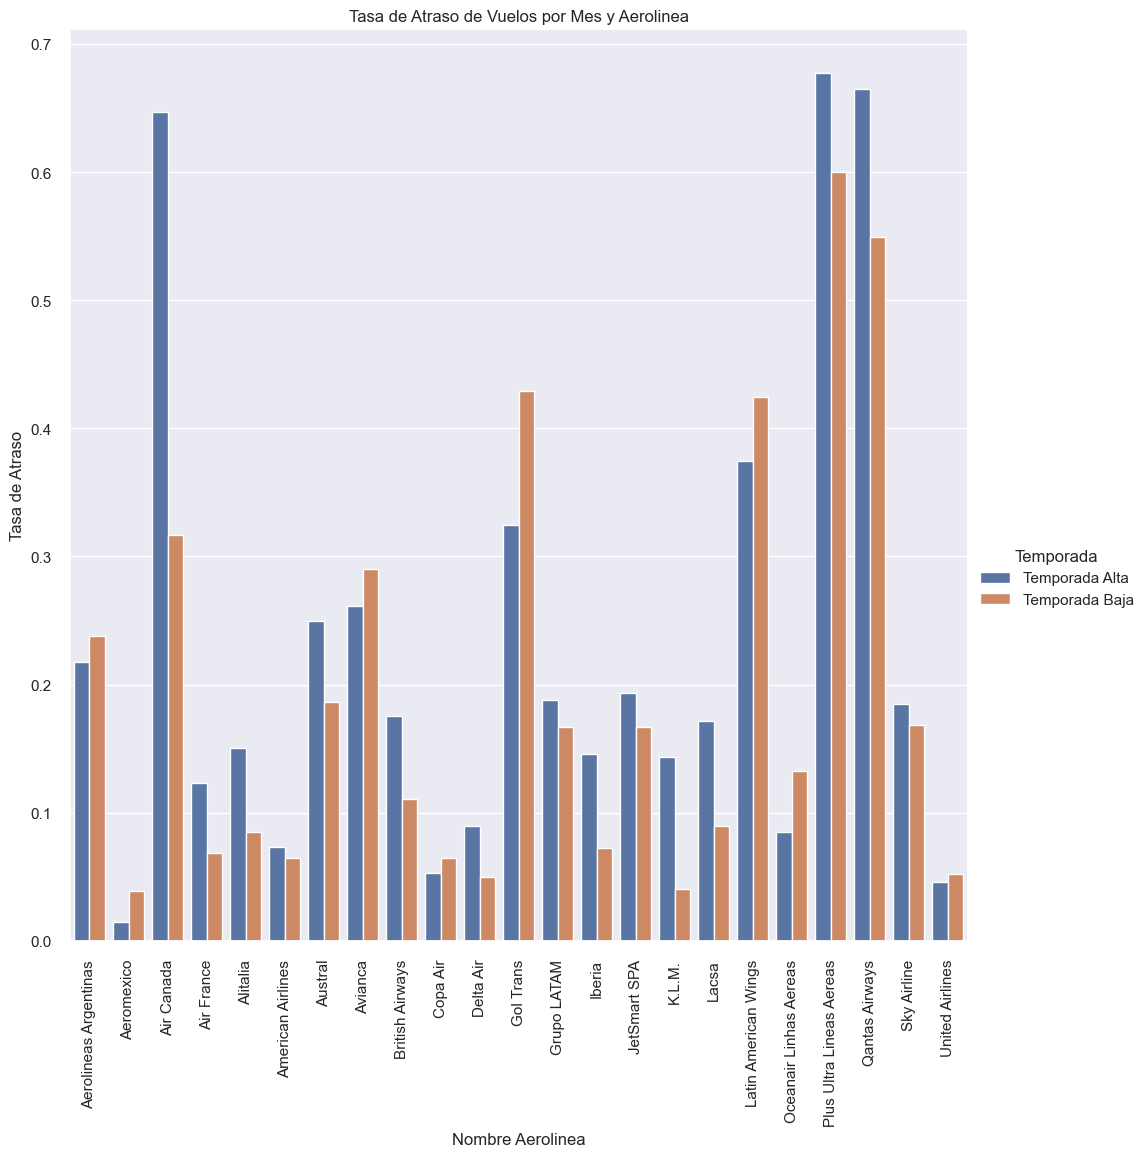

In [56]:
df_piv = calcula_tasa_atraso( df, df_avg, ['OPERA','Temporada'] )


plt.figure(figsize = (60,60))
sns.set(style="darkgrid")

sns.catplot(
    data = df_piv[['OPERA','Temporada','Tasa']], 
    x='OPERA', 
    y = 'Tasa',
    hue = 'Temporada', 
    kind ='bar',
    height = 10
)

plt.title('Tasa de Atraso de Vuelos por Mes y Aerolinea')
plt.ylabel('Tasa de Atraso', fontsize=12)
plt.xlabel('Nombre Aerolinea', fontsize=12)
plt.xticks(rotation=90)
plt.show()

<Figure size 6000x6000 with 0 Axes>

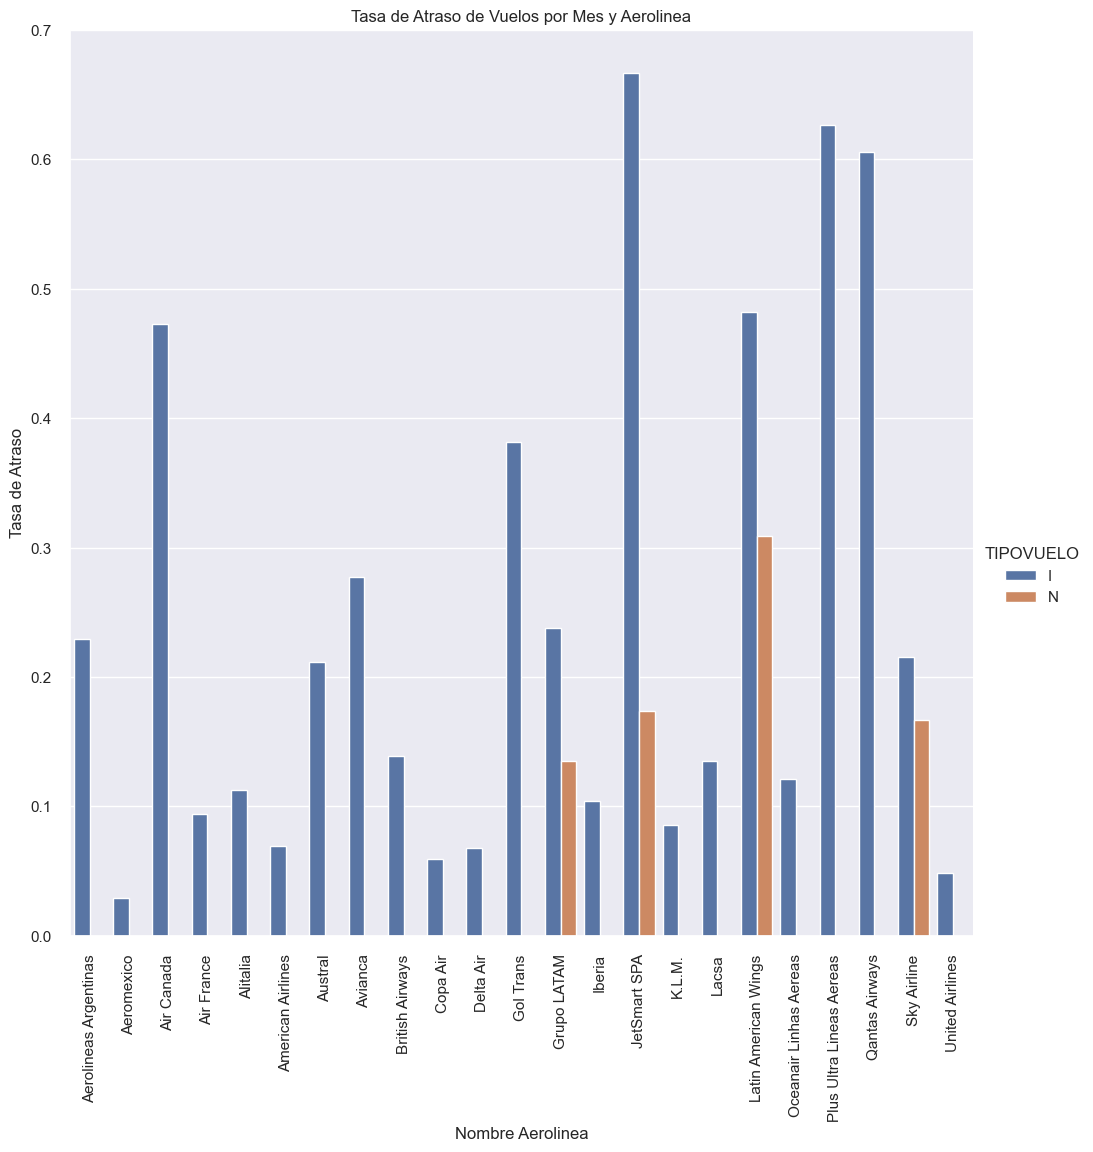

In [57]:
df_piv = calcula_tasa_atraso( df, df_avg, ['OPERA','TIPOVUELO'] )


plt.figure(figsize = (60,60))
sns.set(style="darkgrid")

sns.catplot(
    data = df_piv[['OPERA','TIPOVUELO','Tasa']], 
    x='OPERA', 
    y = 'Tasa',
    hue = 'TIPOVUELO', 
    kind ='bar',
    height = 10
)

plt.title('Tasa de Atraso de Vuelos por Mes y Aerolinea')
plt.ylabel('Tasa de Atraso', fontsize=12)
plt.xlabel('Nombre Aerolinea', fontsize=12)
plt.xticks(rotation=90)
plt.show()

<Figure size 6000x6000 with 0 Axes>

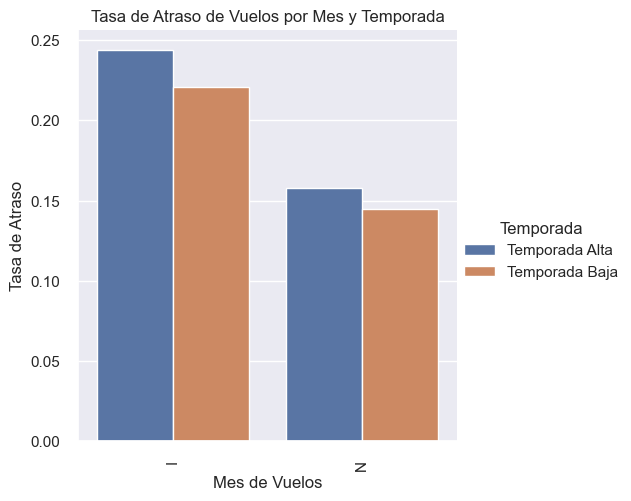

In [58]:
df_piv = calcula_tasa_atraso( df, df_avg, ['TIPOVUELO','Temporada'] )


plt.figure(figsize = (60,60))
sns.set(style="darkgrid")

sns.catplot(
    data = df_piv[['TIPOVUELO','Temporada','Tasa']], 
    x='TIPOVUELO', 
    y = 'Tasa',
    hue = 'Temporada', 
    kind ='bar',
    height = 5
)

plt.title('Tasa de Atraso de Vuelos por Mes y Temporada')
plt.ylabel('Tasa de Atraso', fontsize=12)
plt.xlabel('Mes de Vuelos', fontsize=12)
plt.xticks(rotation=90)
plt.show()

<Figure size 6000x6000 with 0 Axes>

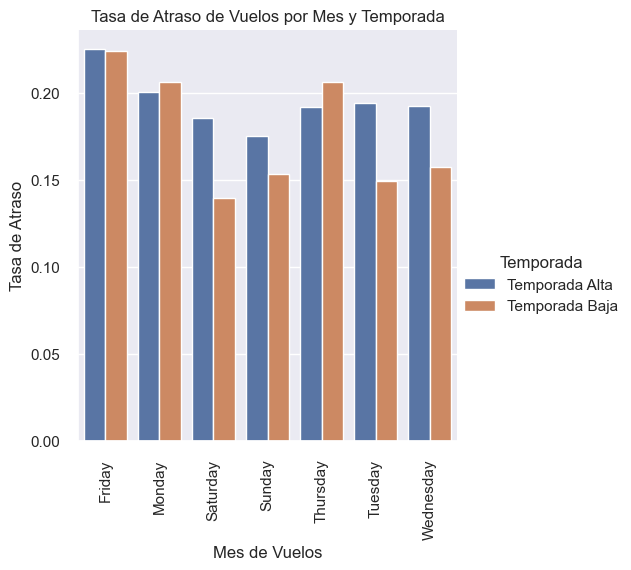

In [59]:
df_piv = calcula_tasa_atraso( df, df_avg, ['Dia_Semana','Temporada'] )


plt.figure(figsize = (60,60))
sns.set(style="darkgrid")

sns.catplot(
    data = df_piv[['Dia_Semana','Temporada','Tasa']], 
    x='Dia_Semana', 
    y = 'Tasa',
    hue = 'Temporada', 
    kind ='bar',
    height = 5
)

plt.title('Tasa de Atraso de Vuelos por Mes y Temporada')
plt.ylabel('Tasa de Atraso', fontsize=12)
plt.xlabel('Mes de Vuelos', fontsize=12)
plt.xticks(rotation=90)
plt.show()

<Figure size 6000x6000 with 0 Axes>

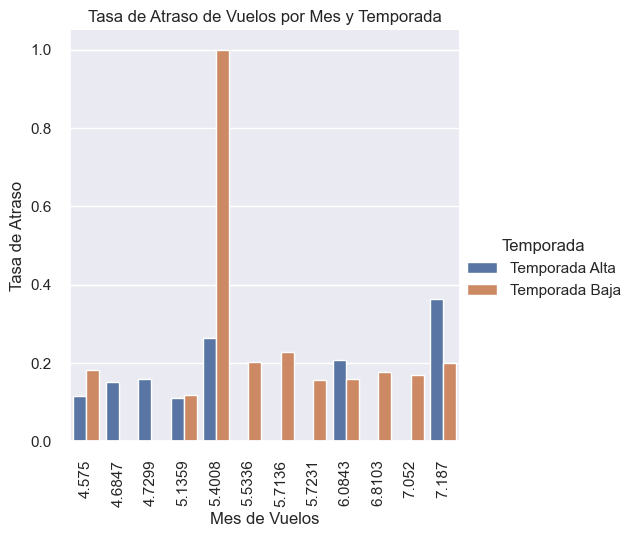

In [60]:
df_piv = calcula_tasa_atraso( df, df_avg, ['Viento_Maximo','Temporada'] )


plt.figure(figsize = (60,60))
sns.set(style="darkgrid")

sns.catplot(
    data = df_piv[['Viento_Maximo','Temporada','Tasa']], 
    x='Viento_Maximo', 
    y = 'Tasa',
    hue = 'Temporada', 
    kind ='bar',
    height = 5
)

plt.title('Tasa de Atraso de Vuelos por Mes y Temporada')
plt.ylabel('Tasa de Atraso', fontsize=12)
plt.xlabel('Mes de Vuelos', fontsize=12)
plt.xticks(rotation=90)
plt.show()

<Figure size 6000x6000 with 0 Axes>

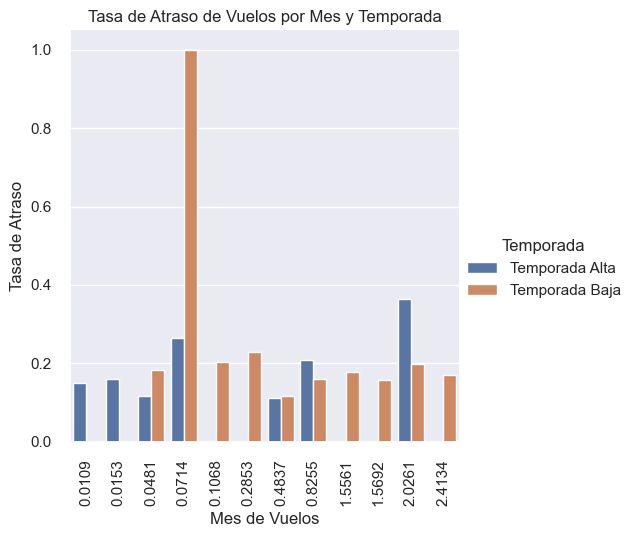

In [61]:
df_piv = calcula_tasa_atraso( df, df_avg, ['Precipitaciones_Muy_Altas','Temporada'] )


plt.figure(figsize = (60,60))
sns.set(style="darkgrid")

sns.catplot(
    data = df_piv[['Precipitaciones_Muy_Altas','Temporada','Tasa']], 
    x='Precipitaciones_Muy_Altas', 
    y = 'Tasa',
    hue = 'Temporada', 
    kind ='bar',
    height = 5
)

plt.title('Tasa de Atraso de Vuelos por Mes y Temporada')
plt.ylabel('Tasa de Atraso', fontsize=12)
plt.xlabel('Mes de Vuelos', fontsize=12)
plt.xticks(rotation=90)
plt.show()

<Figure size 6000x6000 with 0 Axes>

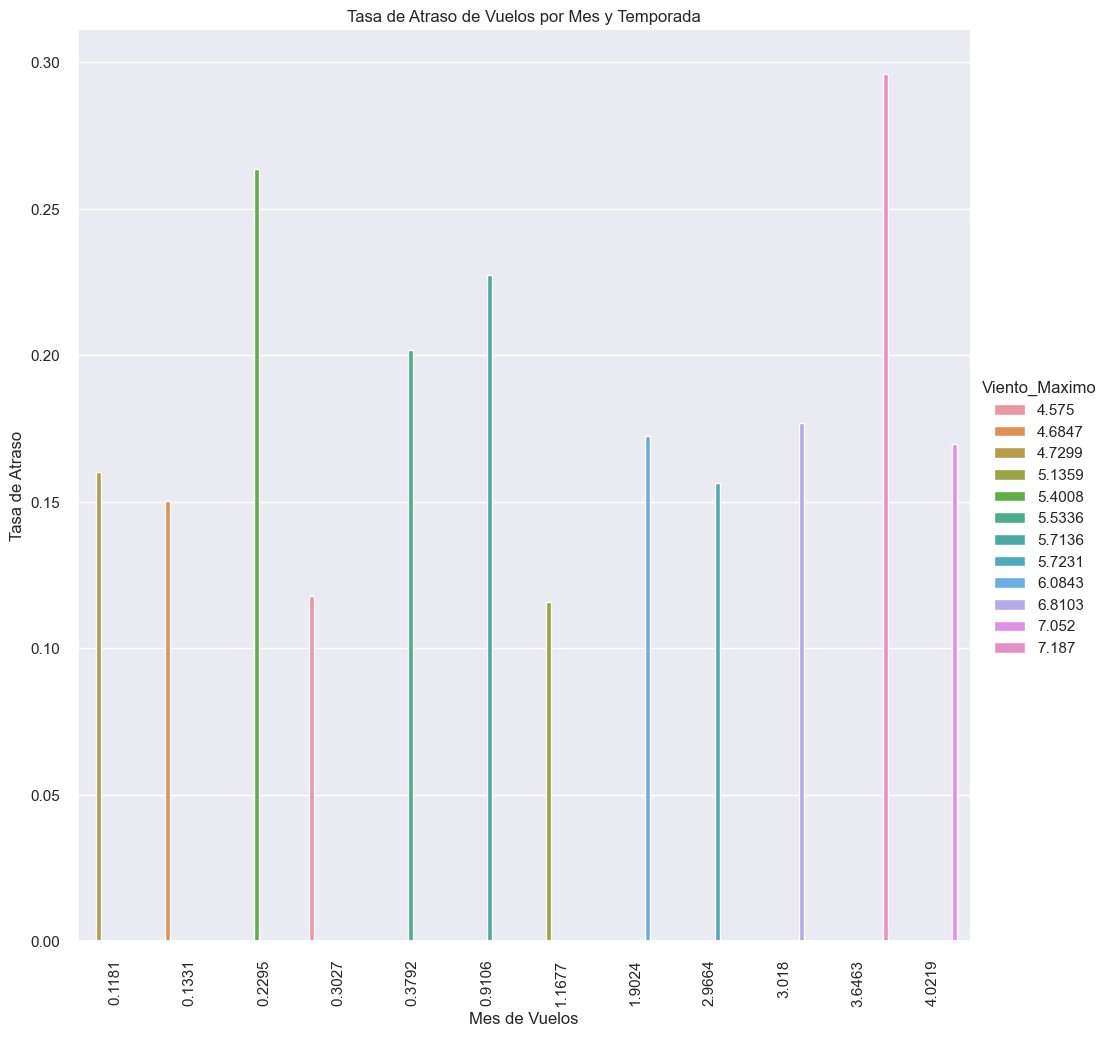

In [62]:
df_piv = calcula_tasa_atraso( df, df_avg, ['Precipitaciones_Altas','Viento_Maximo'] )


plt.figure(figsize = (60,60))
sns.set(style="darkgrid")

sns.catplot(
    data = df_piv[['Precipitaciones_Altas','Viento_Maximo','Tasa']], 
    x='Precipitaciones_Altas', 
    y = 'Tasa',
    hue = 'Viento_Maximo', 
    kind ='bar',
    height = 10
)

plt.title('Tasa de Atraso de Vuelos por Mes y Temporada')
plt.ylabel('Tasa de Atraso', fontsize=12)
plt.xlabel('Mes de Vuelos', fontsize=12)
plt.xticks(rotation=90)
plt.show()

<Figure size 6000x6000 with 0 Axes>

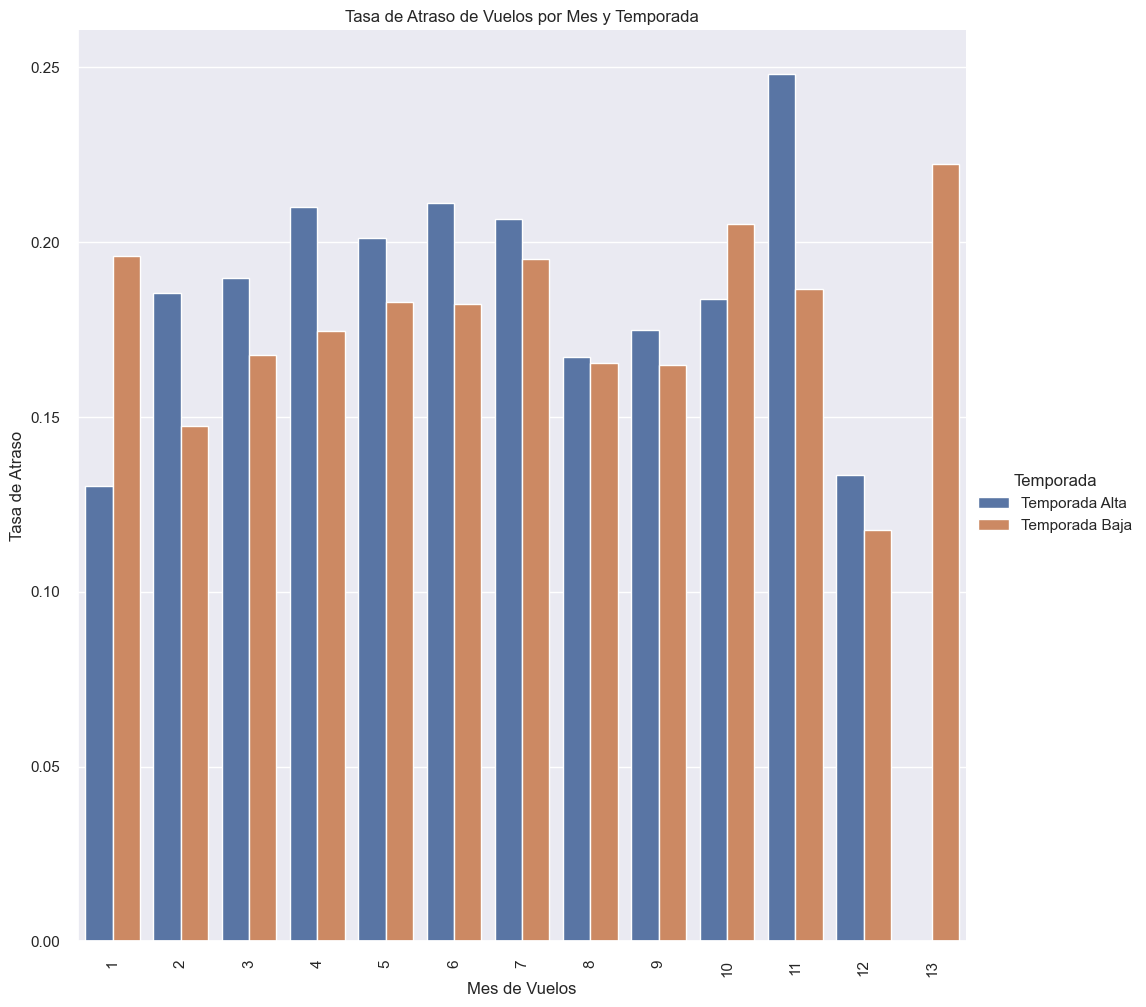

In [63]:
df_piv = calcula_tasa_atraso( df, df_avg, ['Cantidad_Vuelos_Hora','Temporada'] )


plt.figure(figsize = (60,60))
sns.set(style="darkgrid")

sns.catplot(
    data = df_piv[['Cantidad_Vuelos_Hora','Temporada','Tasa']], 
    x='Cantidad_Vuelos_Hora', 
    y = 'Tasa',
    hue = 'Temporada', 
    kind ='bar',
    height = 10
)

plt.title('Tasa de Atraso de Vuelos por Mes y Temporada')
plt.ylabel('Tasa de Atraso', fontsize=12)
plt.xlabel('Mes de Vuelos', fontsize=12)
plt.xticks(rotation=90)
plt.show()

<Figure size 6000x6000 with 0 Axes>

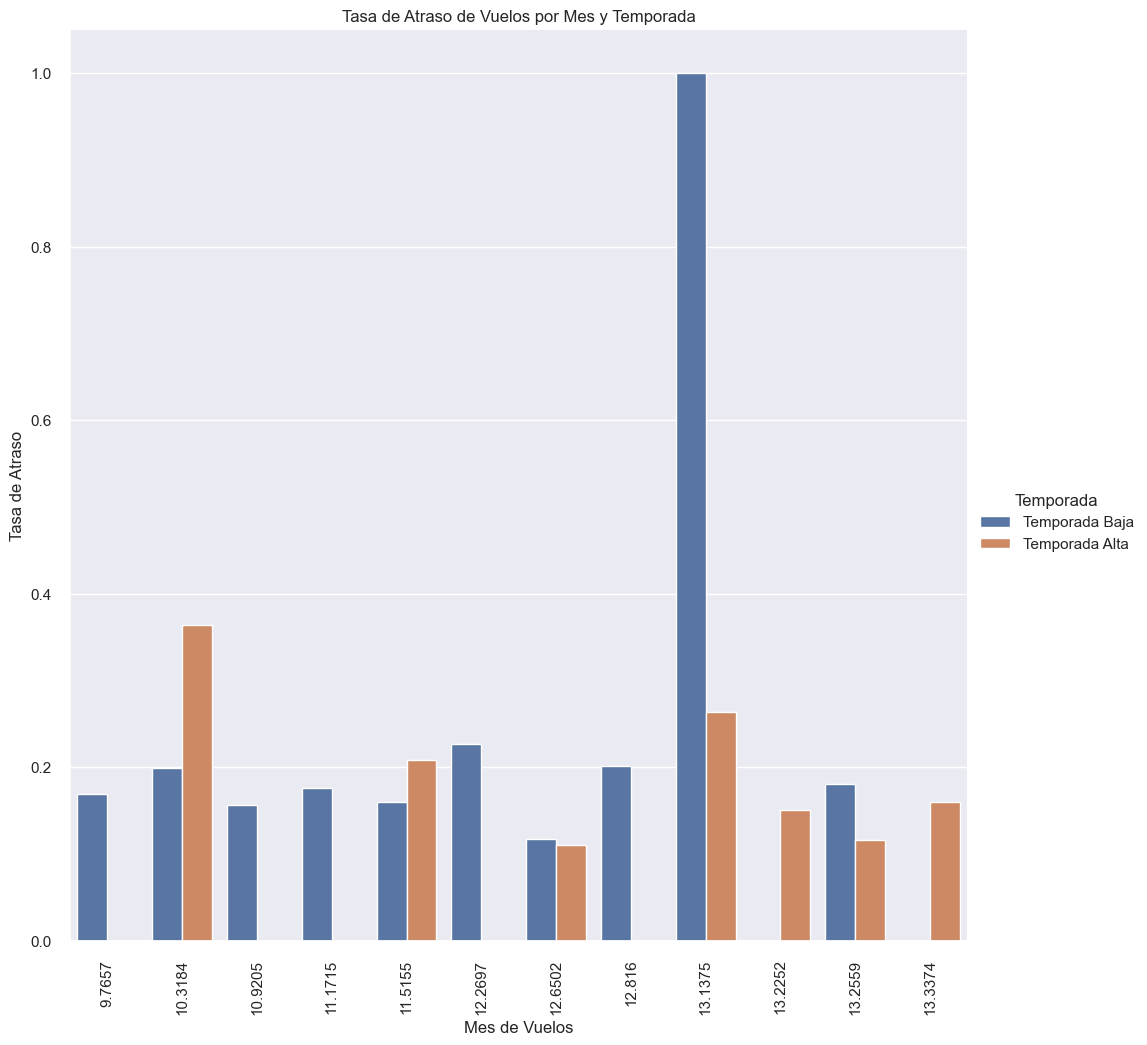

In [64]:
df_piv = calcula_tasa_atraso( df, df_avg, ['Rango_Temperatura','Temporada'] )


plt.figure(figsize = (60,60))
sns.set(style="darkgrid")

sns.catplot(
    data = df_piv[['Rango_Temperatura','Temporada','Tasa']], 
    x='Rango_Temperatura', 
    y = 'Tasa',
    hue = 'Temporada', 
    kind ='bar',
    height = 10
)

plt.title('Tasa de Atraso de Vuelos por Mes y Temporada')
plt.ylabel('Tasa de Atraso', fontsize=12)
plt.xlabel('Mes de Vuelos', fontsize=12)
plt.xticks(rotation=90)
plt.show()

Respecto al análisis realizado se ha podido visualizar los siguientes aspectos relevantes respecto al compartamiento de los datos y la probabilidad de que un vuelo presente un atraso
- Se puede visualizar que existe una mayor probabilidad que se presenten atrasos en los vuelos si es que estos son realizados en los meses que tienen un promedio de precipitaciones y lluvias las cuales alcancen sus máximas anuales.
- Respecto a la demanda de vuelos durante el periodo de temporada alta se puede visualizar que existen destinos los cuales presentan una mayor probabilidad de que reporten atrasos, no obstante, se observan casos puntuales en los que la demanda de vuelos en dichos destinos no es tan alta y en donde la totalidad de sus registros presentan atrasos. Estos valores pueden entorpecer el proceso de entrenamiento del modelo.
- Respecto a la demanda de vuelos, se puede visualizar una mayor demanda para ciertos operadores de vuelos. Los valores más altos de porcentaje de atraso se ven reflejados en los operadores que concentran mayor cantidad de vuelos por día, lo cual podría indicar el esfuerzo que deben realizar para poder realizar la gestión operativa de los vuelos puede afectar en el rendimiento de estos.

### 4. Entrena uno o varios modelos (usando el/los algoritmo(s) que prefieras) para estimar la probabilidad de atraso de un vuelo. Siéntete libre de generar variables adicionales y/o complementar con variables externas.

In [65]:
data = shuffle( df [ [
    'SIGLADES', 'MES', 'DIA', 'OPERA',
    'TIPOVUELO', 'Rango_Temperatura', 'Viento_Maximo', 'Precipitaciones_Altas', 
    'Precipitaciones_Muy_Altas', 'Cantidad_Vuelos_Dia',  'Hora_Vuelo', 'Cantidad_Vuelos_Hora', 
    'Cantidad_Vuelos_Destino', 'Cantidad_Vuelos_Opera', 'Dif_sig_vuelo', 'Vuelos_Acum_Hora',
    'Penalizacion_Viento', 'Penalizacion_Precipitaciones', 'Atraso', 'Dia_Semana', 
    'Temporada', 'Distancia_millas', 'latitud_grados', 'latitud_minutos',
    'latitud_segundos','latitud', 'longitud_grados','longitud_minutos',
    'longitud_segundos','longitud', 'Destino_Sentido', 'Destino_Coordenada',
    'Inicio_Coordenada', 'Inicio_Sentido'
] ], random_state = 111 )

In [ ]:
l_col = [
        'Distancia_millas', 'latitud_grados',
        'latitud_minutos', 'latitud_segundos',
        'longitud_grados', 'longitud_minutos',
        'longitud_segundos', 'Destino_Coordenada',
        'Inicio_Coordenada', 'Rango_Temperatura',
        'Viento_Maximo', 'Precipitaciones_Altas', 
        'Precipitaciones_Muy_Altas', 'Cantidad_Vuelos_Dia', 
        'Hora_Vuelo', 'Cantidad_Vuelos_Hora', 
        'Cantidad_Vuelos_Destino', 'Cantidad_Vuelos_Opera',
        'Dif_sig_vuelo', 'Vuelos_Acum_Hora',
        'Penalizacion_Viento', 'Penalizacion_Precipitaciones',
        'MES', 'DIA', 'Atraso'
        ]

In [66]:
features = pd.concat([
    data[[l_col]],
    pd.get_dummies(data['TIPOVUELO'], prefix = 'TIPOVUELO'), 
    pd.get_dummies(data['OPERA'], prefix = 'OPERA'), 
    pd.get_dummies(data['Dia_Semana'], prefix = 'Dia_Semana'),
    pd.get_dummies(data['Temporada'], prefix = 'Temporada'),
    pd.get_dummies(data['latitud'], prefix = 'latitud'), 
    pd.get_dummies(data['longitud'], prefix = 'longitud'), 
    pd.get_dummies(data['Destino_Sentido'], prefix = 'Destino_Sentido'), 
    pd.get_dummies(data['Inicio_Sentido'], prefix = 'Inicio_Sentido'), 
], axis = 1)

In [ ]:
l_col.append('SIGLADES')

In [126]:
deep_features = pd.concat([
    data[l_col],
    pd.get_dummies(data['TIPOVUELO'], prefix = 'TIPOVUELO'), 
    pd.get_dummies(data['OPERA'], prefix = 'OPERA'), 
    pd.get_dummies(data['Dia_Semana'], prefix = 'Dia_Semana'),
    pd.get_dummies(data['Temporada'], prefix = 'Temporada'),
    pd.get_dummies(data['latitud'], prefix = 'latitud'), 
    pd.get_dummies(data['longitud'], prefix = 'longitud'), 
    pd.get_dummies(data['Destino_Sentido'], prefix = 'Destino_Sentido'), 
    pd.get_dummies(data['Inicio_Sentido'], prefix = 'Inicio_Sentido'), 
], axis = 1)

In [67]:
features = features.astype('float')
label = data['Atraso']

In [68]:
x_train, x_test, y_train, y_test = train_test_split(features, label, test_size = 0.33, random_state = 42)

In [69]:
x_train.shape, x_test.shape

((54943, 77), (27062, 77))

In [70]:
y_train.value_counts('%')

0    0.813934
1    0.186066
Name: Atraso, dtype: float64

In [115]:
y_test.value_counts('%')

0    0.81487
1    0.18513
Name: Atraso, dtype: float64

#### Entrenamiento Modelo LGBMClassifier

In [82]:
lightgbm = ltb.LGBMClassifier(
    boosting_type='dart', 
    importance_type='split', 
    learning_rate=0.339,
    max_depth=89, 
    min_child_samples=20,
    min_child_weight=0.0909, 
    min_split_gain=0.0,
    n_estimators=126,
    num_leaves=178,
    reg_alpha=0.0, 
    reg_lambda=0.0,
    subsample=1.0, 
    subsample_for_bin=200000, 
    subsample_freq=0
)

In [83]:
model = lightgbm.fit(x_train, y_train)

In [84]:
y_pred = model.predict(x_test)

In [85]:
confusion_matrix(y_test, y_pred)

array([[21440,   612],
       [ 3659,  1351]], dtype=int64)

In [86]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.97      0.91     22052
           1       0.69      0.27      0.39      5010

    accuracy                           0.84     27062
   macro avg       0.77      0.62      0.65     27062
weighted avg       0.82      0.84      0.81     27062



#### Entrenamiento Modelo RandomForestClassifier

In [76]:
rf = RandomForestClassifier(
    criterion='gini', 
    max_features='sqrt'
)

In [77]:
rf_model = rf.fit(x_train, y_train)

In [78]:
y_pred = rf_model.predict(x_test)

In [79]:
confusion_matrix(y_test, y_pred)

array([[21336,   716],
       [ 3285,  1725]], dtype=int64)

In [80]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.97      0.91     22052
           1       0.71      0.34      0.46      5010

    accuracy                           0.85     27062
   macro avg       0.79      0.66      0.69     27062
weighted avg       0.84      0.85      0.83     27062



#### Entrenamiento Modelo XGBClassifier

In [90]:
modelxgb = xgb.XGBClassifier(
    random_state=1, 
    learning_rate=0.339,
    max_depth=89, 
    min_child_weight=0.0909, 
    n_estimators=126,
    reg_alpha=0.0, 
    reg_lambda=0.0
)

In [91]:
modelxgb = modelxgb.fit(x_train, y_train)

In [92]:
y_predxgb = modelxgb.predict(x_test)

In [93]:
confusion_matrix(y_test, y_predxgb)

array([[20723,  1329],
       [ 2861,  2149]], dtype=int64)

In [94]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.97      0.91     22052
           1       0.69      0.27      0.39      5010

    accuracy                           0.84     27062
   macro avg       0.77      0.62      0.65     27062
weighted avg       0.82      0.84      0.81     27062



#### Se validan caracteristicas más importantes

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

<Figure size 1300x1000 with 0 Axes>

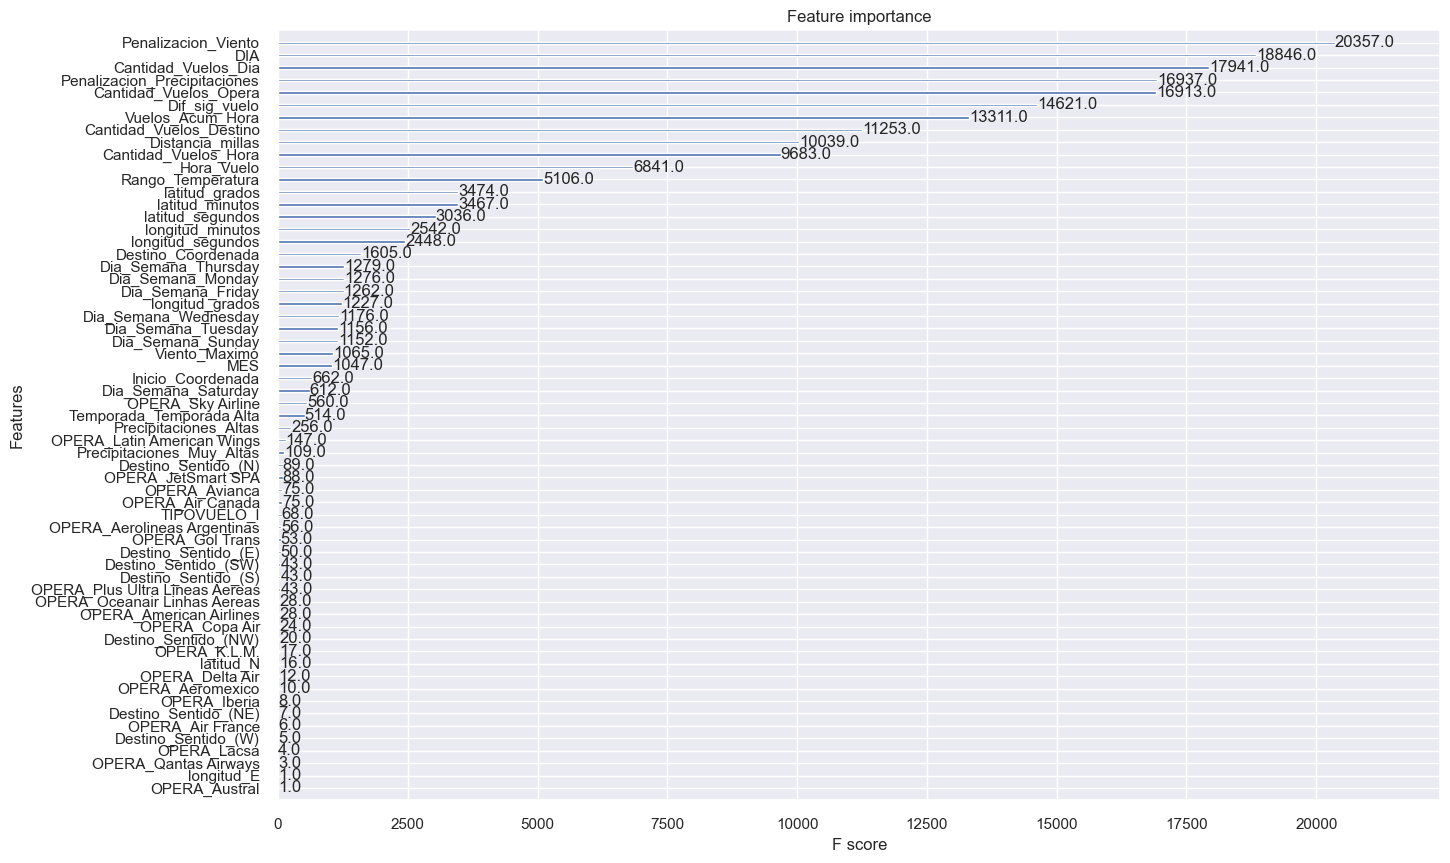

In [97]:
plt.figure(figsize = (13,10))
plot_importance(modelxgb)

In [99]:
features_i = features[[
    'Distancia_millas','latitud_grados', 'latitud_minutos','latitud_segundos',
    'longitud_grados','longitud_minutos', 'longitud_segundos','Inicio_Coordenada',
    'Rango_Temperatura','Viento_Maximo', 'Precipitaciones_Altas', 'Precipitaciones_Muy_Altas',
    'Cantidad_Vuelos_Dia', 'Hora_Vuelo', 'Cantidad_Vuelos_Hora', 'Cantidad_Vuelos_Destino', 
    'Cantidad_Vuelos_Opera','Dif_sig_vuelo', 'Vuelos_Acum_Hora','Penalizacion_Viento',
    'Penalizacion_Precipitaciones','MES', 'DIA','Dia_Semana_Friday',
    'Dia_Semana_Monday', 'Dia_Semana_Saturday', 'Dia_Semana_Sunday','Dia_Semana_Thursday', 
    'Dia_Semana_Tuesday', 'Dia_Semana_Wednesday', 'Temporada_Temporada Alta', 'Temporada_Temporada Baja'
]]

In [101]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(features_i, label, test_size = 0.33, random_state = 42)

#### Entrenamiento Modelo XGBClassifier utilizando únicamente los datos más relevantes

In [102]:
modelxgb = xgb.XGBClassifier(
    random_state=1, 
    learning_rate=0.339,
    max_depth=89, 
    min_child_weight=0.0909, 
    n_estimators=126,
    reg_alpha=0.0, 
    reg_lambda=0.0
)

In [103]:
modelxgb = modelxgb.fit(x_train2, y_train2)

In [104]:
y_pred = modelxgb.predict(x_test2)

In [105]:
confusion_matrix(y_test2, y_pred)

array([[20473,  1579],
       [ 2891,  2119]], dtype=int64)

In [106]:
print(classification_report(y_test2, y_predxgb))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90     22052
           1       0.57      0.42      0.49      5010

    accuracy                           0.83     27062
   macro avg       0.72      0.68      0.69     27062
weighted avg       0.82      0.83      0.82     27062



#### Entrenamiento Modelo LGBMClassifier utilizando únicamente los datos más relevantes

In [107]:
lightgbm = ltb.LGBMClassifier(
    boosting_type='dart', 
    importance_type='split', 
    learning_rate=0.339,
    max_depth=89, 
    min_child_samples=20,
    min_child_weight=0.0909, 
    min_split_gain=0.0,
    n_estimators=126,
    num_leaves=178,
    reg_alpha=0.0, 
    reg_lambda=0.0,
    subsample=1.0, 
    subsample_for_bin=200000, 
    subsample_freq=0
)

In [108]:
model_ltb = lightgbm.fit(x_train2, y_train2)

In [109]:
y_pred = model_ltb.predict(x_test2)

In [110]:
confusion_matrix(y_test2, y_pred)

array([[21436,   616],
       [ 3734,  1276]], dtype=int64)

In [112]:
print(classification_report(y_test2, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.97      0.91     22052
           1       0.67      0.25      0.37      5010

    accuracy                           0.84     27062
   macro avg       0.76      0.61      0.64     27062
weighted avg       0.82      0.84      0.81     27062



#### Entrenamiento Modelo RandomForestClassifier utilizando únicamente los datos más relevantes

In [113]:
rf = RandomForestClassifier(
    criterion='gini', 
    max_features='sqrt'
)

In [114]:
rf_model = rf.fit(x_train2, y_train2)

In [115]:
y_pred = rf_model.predict(x_test2)

In [116]:
confusion_matrix(y_test2, y_pred)

array([[21311,   741],
       [ 3342,  1668]], dtype=int64)

In [117]:
print(classification_report(y_test2, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.97      0.91     22052
           1       0.69      0.33      0.45      5010

    accuracy                           0.85     27062
   macro avg       0.78      0.65      0.68     27062
weighted avg       0.83      0.85      0.83     27062



### 5. Evalúa tu modelo. ¿Qué performance tiene? ¿Qué métricas usaste para evaluar esa performance y por qué? ¿Por qué elegiste ese algoritmo en particular? ¿Qué variables son las que más influyen en la predicción? ¿Cómo podrías mejorar laperformance?

Los modelos utilizados en la sección anterior fueron:
* **RandomForestClassifier**: Fue seleccionado ya que es un modelo simple y permite visualizar rapidamente el rendimiento del modelo en primera instancia.
* **XGBClassifier**: Este modelo fue seleccionado debido que cuenta con un gran desempeño, además de que permite visualizar las caracteristicas que tienen mayor relevancia en la predicción de los modelos.
* **LGBMClassifier**: Fue seleccionado porque en general es un modelo que entrega buenos resultados y facilita en gran medida la configuración de sus hiperparámetros.

Los resultados obtenidos con los 3 modelos en general fueron deficientes. No obstante, al validar los resultados tras someter el modelo a las muestras de vuelos por cada ciudad, se puede visualizar una mejoria considerable, lo cual podría corroborar la hipotesis inicial respecto a la calidad de datos que presente ciertos destinos, siendo estos limitados, lo cual no permitiría al modelo realizar un entrenamiento adecuado.

Para mejor el performance se podría reforzar el proceso de entrenamiento por ciudad, cuidando que los modelos no vayan registrando un sobreajuste en su funcionamiento. Adicionalmente se un proceso para configurar los hiperparámetros de cada modelo, con la finalidad de evaluar si es que estos pueden presentar alguna mejora.

In [152]:
def Evalua_Modelo_Destino( df, model, l_features ):

    df_export = pd.DataFrame()

    for i in df['SIGLADES'].drop_duplicates().values:

        x_test = df[ df['SIGLADES'] == i ][l_features]
        y_test = df[ df['SIGLADES'] == i ][['Atraso']]

        y_pred = model.predict(x_test)

        report = classification_report(y_test, y_pred, output_dict=True)

        df_report = pd.DataFrame(report).reset_index()

        df_report['SIGLADES'] = i

        df_export = pd.concat([df_export,df_report])

    return df_export

In [177]:
deep_features[ features_i.columns.values ] = deep_features[ features_i.columns.values ].astype('float')

In [178]:
df_export = Evalua_Modelo_Destino( deep_features, modelxgb, features_i.columns.values )

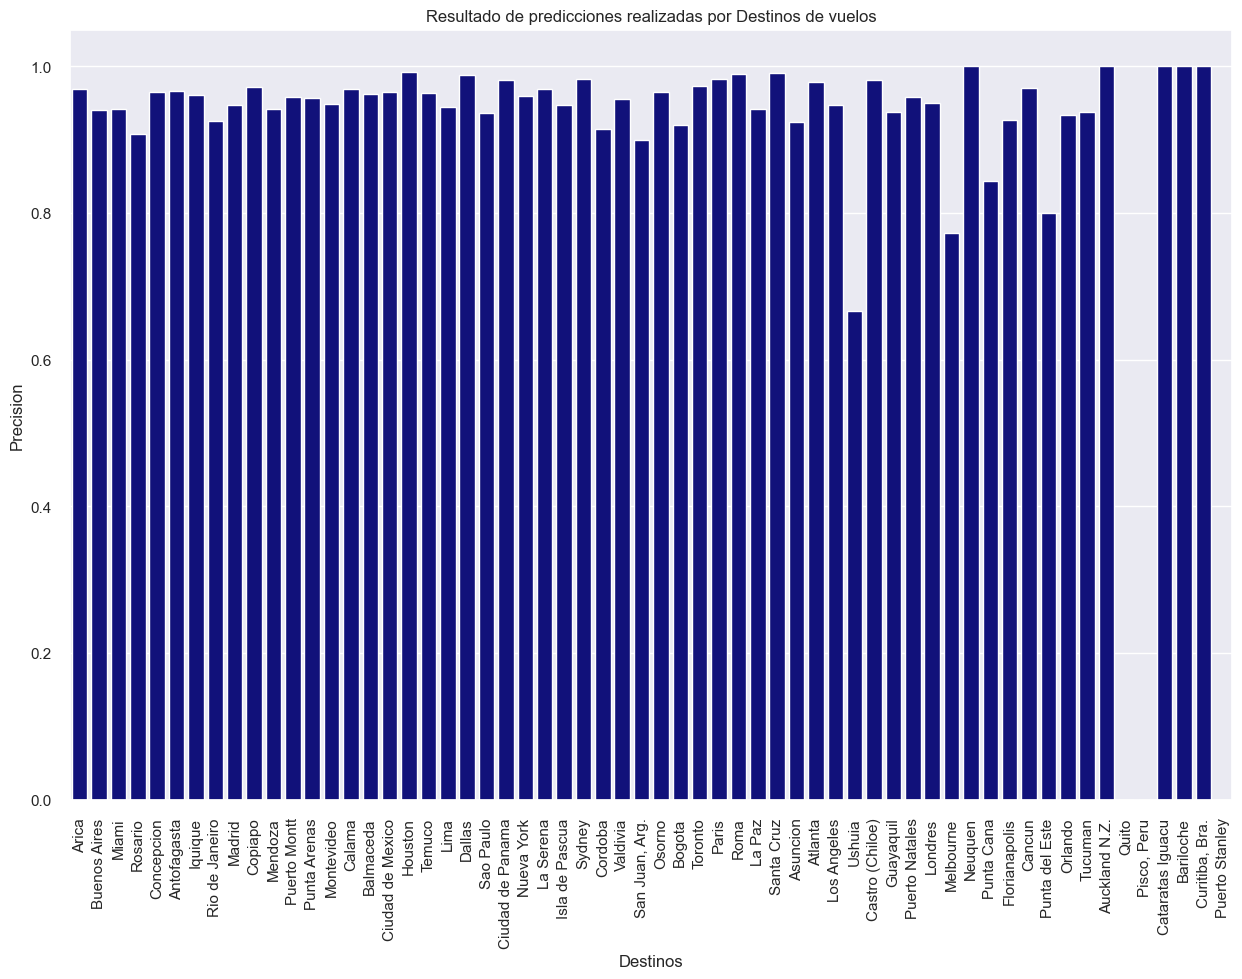

In [179]:
sns.barplot(
    data = df_export[ df_export['index'] == 'precision' ][['0','SIGLADES']],
    x = 'SIGLADES',
    y = '0',
    color = 'darkblue'
)

plt.title('Resultado de predicciones realizadas por Destinos de vuelos')
plt.ylabel('Precision', fontsize=12)
plt.xlabel('Destinos', fontsize=12)
plt.xticks(rotation=90)
plt.show()

In [181]:
df_export[ df_export['index'].isin(['precision','recall']) ]

,index,0,1,accuracy,macro avg,weighted avg,SIGLADES
0,precision,0.969890,0.868715,0.956554,0.919302,0.955660,Arica
1,recall,0.979863,0.814136,0.956554,0.897000,0.956554,Arica
0,precision,0.941217,0.905889,0.932791,0.923553,0.932002,Buenos Aires
1,recall,0.969632,0.828384,0.932791,0.899008,0.932791,Buenos Aires
0,precision,0.941899,0.895954,0.934457,0.918927,0.932994,Miami
...,...,...,...,...,...,...,...
1,recall,1.000000,1.000000,1.000000,1.000000,1.000000,Bariloche
0,precision,1.000000,NaN,1.000000,1.000000,1.000000,"Curitiba, Bra."
1,recall,1.000000,NaN,1.000000,1.000000,1.000000,"Curitiba, Bra."
0,precision,0.000000,0.000000,0.000000,0.000000,0.000000,Puerto Stanley


#### Modificación de hiperparametros de modelos

- **XGBoost**

In [187]:
parameters = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 150],
    'subsample': [0.5, 0.9]
}

modelxgb_GridCV = GridSearchCV(
    modelxgb, 
    param_grid = parameters,
    cv = 2, 
    n_jobs=-1, 
    verbose=1
).fit(x_train2, y_train2)

y_pred = modelxgb_GridCV.predict(x_test)

print( pd.DataFrame( classification_report( y_test, y_pred, output_dict=True ) ) )

Fitting 2 folds for each of 18 candidates, totalling 36 fits
                      0            1  accuracy     macro avg  weighted avg
precision      0.867381     0.700360  0.851933      0.783870      0.836460
recall         0.965989     0.349900  0.851933      0.657945      0.851933
f1-score       0.914033     0.466658  0.851933      0.690345      0.831210
support    22052.000000  5010.000000  0.851933  27062.000000  27062.000000


- **RandomForest**

In [189]:
parameters = {
    'n_estimators': [50, 100, 150]
}

modelrf_GridCV = GridSearchCV(
    rf, 
    param_grid = parameters,
    cv = 2, 
    n_jobs=-1, 
    verbose=1
).fit(x_train2, y_train2)

y_pred = modelrf_GridCV.predict(x_test)

print( pd.DataFrame( classification_report( y_test, y_pred, output_dict=True ) ) )

Fitting 2 folds for each of 3 candidates, totalling 6 fits
                      0            1  accuracy     macro avg  weighted avg
precision      0.866018     0.713867  0.852598      0.789943      0.837850
recall         0.969028     0.340120  0.852598      0.654574      0.852598
f1-score       0.914632     0.460727  0.852598      0.687680      0.830600
support    22052.000000  5010.000000  0.852598  27062.000000  27062.000000


- **LGBMClassifier**

In [190]:
parameters = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 150],
    'subsample': [0.5, 0.9]
}

modelltb_GridCV = GridSearchCV(
    model_ltb, 
    param_grid = parameters,
    cv = 2, 
    n_jobs=-1, 
    verbose=1
).fit(x_train2, y_train2)

y_pred = modelltb_GridCV.predict(x_test)

print( pd.DataFrame( classification_report( y_test, y_pred, output_dict=True ) ) )

Fitting 2 folds for each of 18 candidates, totalling 36 fits
                      0            1  accuracy     macro avg  weighted avg
precision      0.843342     0.706638  0.836265      0.774990      0.818034
recall         0.981362     0.197605  0.836265      0.589484      0.836265
f1-score       0.907132     0.308844  0.836265      0.607988      0.796371
support    22052.000000  5010.000000  0.836265  27062.000000  27062.000000


## Conclusión
Los modelos evaluados no presentaron una mejoria respecto a su funcionamiento general posterior a la configuración de sus hiperparametros, no obstante, el rendimiento individual de estos respecto a cada lugar de destino se ve bastante estable. Es posible que con un dataset con registros historicos más nutrido pueda generar mejores resultados para los destinos que tuvieron un rendimiento deficiente.